# Predicting weather related damage costs by county

## Read packages and open-source data files

In [1]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
#dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

import statistics


In [2]:
census_df = pd.read_csv('cre2.csv')
census_df.columns

Index(['CountyFIPS', 'GeoId', 'GeoTemp', 'Name', 'StateFIPS', '65 plus PE',
       '65 plus PF', 'Blw Pov Lvl PE', 'Blw Pov Lvl PF', 'Blw Pov Lvl PM',
       ...
       'Pred3 Pm', 'Rent Vac PE', 'Rent Vac PF', 'Rent Vac PM', 'Rural Pop PE',
       'Rural Pop PF', 'Total Population E', 'Wrk Ft Yr Pe', 'Wrk Ft Yr Pf',
       'Wrk Ft Yr Pm'],
      dtype='object', length=102)

In [3]:
weather_df = pd.read_csv('NOAA_Clusters_All_Counties.csv')
weather_df['location'] = weather_df['County']+", "+weather_df['State']
del weather_df['cluster']
weather_df.columns

Index(['Drought', 'Fire and Related Events', 'Flood and Related Events',
       'Marine and Tropical Storm Events', 'Severe Storms and Related Events',
       'Winter Storms and Related Events', 'State', 'County', 'location'],
      dtype='object')

In [4]:
#https://www.fema.gov/openfema-data-page/public-assistance-funded-projects-details-v1

pa_df = pd.read_csv('PublicAssistanceFundedProjectsDetails.csv',parse_dates=['declarationDate'],
                   dtype = {
                       'disasterNumber': int,
                       'declarationDate': str,
                       'incidentType': str,
                       'pwNumber': int,
                       'applicationTitle': str,
                       'applicantId': str,
                       'damageCategoryCode': str,
                       'projectSize': str,
                       'county': str,
                       'countyCode': 'Int64',
                       'state': str,
                       'stateCode': str,
                       'stateNumberCode': int, 
                       'projectAmount': float,
                       'federalShareObligated': float,
                       'totalObligated': float,
                       'obligatedDate': str,
                       'dcc': str,
                       'damageCategory': str,
                       'lastRefresh': str,
                       'hash': str,
                       'id': str })

In [5]:
pa_df['Year'] = pa_df['declarationDate'].dt.year
pa_df['location'] = pa_df['county'].str.upper()+", "+pa_df['state'].str.upper()

In [6]:
pa_df['projectAmount'].sum()

220733575136.55005

<AxesSubplot:xlabel='Year'>

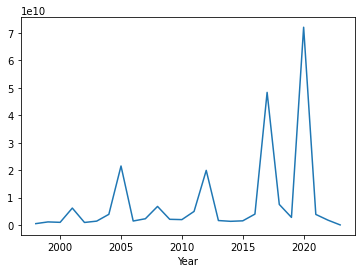

In [7]:
pa_df.groupby('Year')['projectAmount'].sum().plot()

<AxesSubplot:xlabel='Year'>

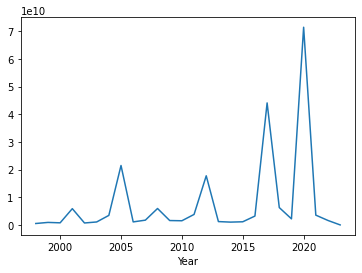

In [8]:
pa_df.groupby('Year')['totalObligated'].sum().plot()

In [9]:
ia_owners_df = pd.read_csv('HousingAssistanceOwners.csv',
                          dtype = {
                        'disasterNumber': int,
                        'state': str,
                        'county': str,
                        'city': str,
                        'zipCode': str,
                        'validRegistrations': int,
                        'averageFemaInspectedDamage': float,
                        'totalInspected': int,
                        'totalDamage': float,
                        'noFemaInspectedDamage': int,
                        'femaInspectedDamageBetween1And10000': int,
                        'femaInspectedDamageBetween10001And20000': int,
                        'femaInspectedDamageBetween20001And30000': int,
                        'femaInspectedDamageGreaterThan30000': int,
                        'approvedForFemaAssistance': int,
                        'totalApprovedIhpAmount': float,
                        'repairReplaceAmount': float,
                        'rentalAmount': float,
                        'otherNeedsAmount': float,
                        'approvedBetween1And10000': int,
                        'approvedBetween10001And25000': int,
                        'approvedBetween25001AndMax': int,
                        'totalMaxGrants': int,
                        'id': str})

In [10]:
ia_renters_df = pd.read_csv('HousingAssistanceRenters.csv', 
                           dtype = {
                               'disasterNumber': int,
                               'state': str,
                               'county': str,
                               'city': str,
                               'zipCode': str,
                                'validRegistrations': int,
                                'totalInspected': int,
                                'totalInspectedWithNoDamage': int,
                                'totalWithModerateDamage': int,
                                'totalWithMajorDamage': int, 
                                'totalWithSubstantialDamage': int,
                                'approvedForFemaAssistance': int,
                                'totalApprovedIhpAmount': float,
                                'repairReplaceAmount': float,
                                'rentalAmount': float,
                                'otherNeedsAmount': float,
                                'approvedBetween1And10000': int,
                                'approvedBetween10001And25000': int,
                                'approvedBetween25001AndMax': int,
                                'totalMaxGrants': float,
                                'id': str})

## County clusters using NOAA weather occurrences by type

### create a cluster of counties using Kmeans

In [11]:
weather_temp_df = pd.read_csv('NOAA_Clusters_All_Counties.csv')
weather_temp_df['location'] = weather_temp_df['County']+", "+weather_temp_df['State']

# remove the county titles from the DataFrame so only the measurements are left
county_state = list(weather_temp_df['location'])
del weather_temp_df['cluster']
del weather_temp_df['location']
del weather_temp_df['State']
del weather_temp_df['County']

In [12]:
# Extract all the measurements as a 2D NumPy array, assigning to samples
samplesW = weather_temp_df.values

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
kmeans = KMeans(n_clusters=5)
pipeline = make_pipeline(scaler, kmeans)

In [13]:
pipeline.fit(samplesW)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=5))])

In [14]:
labelsW = pipeline.predict(samplesW)

In [15]:
cluster_temp_df = pd.DataFrame({'cluster': labelsW, 'location': county_state})

In [16]:
cluster_temp_df

,cluster,location
0,0,"AUTAUGA, ALABAMA"
1,0,"BALDWIN, ALABAMA"
2,0,"BARBOUR, ALABAMA"
3,0,"BIBB, ALABAMA"
4,0,"BLOUNT, ALABAMA"
...,...,...
3057,0,"SWEETWATER, WYOMING"
3058,0,"TETON, WYOMING"
3059,0,"UINTA, WYOMING"
3060,0,"WASHAKIE, WYOMING"


### merge cluster with weather details

In [17]:
# merge weather clusters with weather event counts
weather_clusters_df = pd.merge(weather_df, cluster_temp_df, how='outer', on='location')

In [18]:
weather_clusters_df.columns

Index(['Drought', 'Fire and Related Events', 'Flood and Related Events',
       'Marine and Tropical Storm Events', 'Severe Storms and Related Events',
       'Winter Storms and Related Events', 'State', 'County', 'location',
       'cluster'],
      dtype='object')

In [19]:
weather_clusters_df.groupby('cluster')['location'].count()

cluster
0    1737
1     769
2     255
3     298
4       3
Name: location, dtype: int64

In [20]:
weather_clusters_df[weather_clusters_df['cluster']==1]

,Drought,Fire and Related Events,Flood and Related Events,Marine and Tropical Storm Events,Severe Storms and Related Events,Winter Storms and Related Events,State,County,location,cluster
21,27,0,66,3,496,97,ALABAMA,CULLMAN,"CULLMAN, ALABAMA",1
24,34,2,66,3,524,116,ALABAMA,DEKALB,"DEKALB, ALABAMA",1
29,23,2,22,3,244,94,ALABAMA,FRANKLIN,"FRANKLIN, ALABAMA",1
35,35,0,55,3,376,123,ALABAMA,JACKSON,"JACKSON, ALABAMA",1
39,28,1,38,2,325,98,ALABAMA,LAWRENCE,"LAWRENCE, ALABAMA",1
...,...,...,...,...,...,...,...,...,...,...
3035,10,0,11,0,302,98,WISCONSIN,WAUPACA,"WAUPACA, WISCONSIN",1
3036,6,0,11,0,229,96,WISCONSIN,WAUSHARA,"WAUSHARA, WISCONSIN",1
3037,5,0,17,5,322,85,WISCONSIN,WINNEBAGO,"WINNEBAGO, WISCONSIN",1
3038,18,0,21,0,267,94,WISCONSIN,WOOD,"WOOD, WISCONSIN",1


### weather clusters summarized, boxplots

In [21]:
#df3.groupby(["X"]).get_group("A")
#grouped = df.groupby(["A", "B"], as_index=False)


grouped = weather_clusters_df.groupby(by='cluster', as_index=False)

df.groupby("A", as_index=False)[["C", "D"]].agg("sum")

animals.groupby("kind")[["height"]].agg(lambda x: x.astype(int).sum())
    
    
animals.groupby("kind").agg(
    min_height=pd.NamedAgg(column="height", aggfunc="min"),
    max_height=pd.NamedAgg(column="height", aggfunc="max"),
    average_weight=pd.NamedAgg(column="weight", aggfunc="mean"),
)

In [22]:
print("Mean number of events per cluster")
weather_clusters_df.groupby(by='cluster', as_index=False)[['Drought', 'Fire and Related Events', 'Flood and Related Events',
       'Marine and Tropical Storm Events', 'Severe Storms and Related Events',
       'Winter Storms and Related Events']].mean().astype(int)

Mean number of events per cluster


,cluster,Drought,Fire and Related Events,Flood and Related Events,Marine and Tropical Storm Events,Severe Storms and Related Events,Winter Storms and Related Events
0,0,8,0,28,3,139,33
1,1,15,0,42,0,260,140
2,2,15,2,150,5,524,64
3,3,62,7,34,1,230,41
4,4,18,7,178,295,583,11


In [23]:
print("Maximum number of events per cluster")
weather_clusters_df.groupby(by='cluster', as_index=False)[['Drought', 'Fire and Related Events', 'Flood and Related Events',
       'Marine and Tropical Storm Events', 'Severe Storms and Related Events',
       'Winter Storms and Related Events']].max().astype(int)

Maximum number of events per cluster


,cluster,Drought,Fire and Related Events,Flood and Related Events,Marine and Tropical Storm Events,Severe Storms and Related Events,Winter Storms and Related Events
0,0,49,17,162,74,565,107
1,1,60,19,148,51,674,492
2,2,71,80,754,74,1570,314
3,3,174,87,352,34,1195,122
4,4,30,15,201,327,715,33


0    AxesSubplot(0.1,0.857865;0.8x0.0421348)
1    AxesSubplot(0.1,0.807303;0.8x0.0421348)
2    AxesSubplot(0.1,0.756742;0.8x0.0421348)
3     AxesSubplot(0.1,0.70618;0.8x0.0421348)
4    AxesSubplot(0.1,0.655618;0.8x0.0421348)
dtype: object

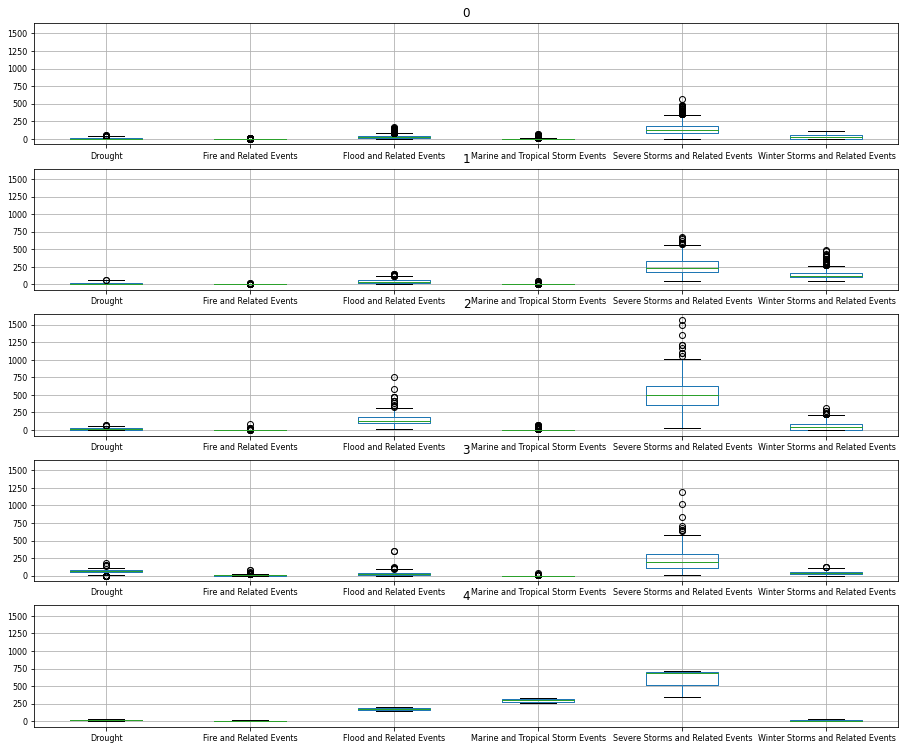

In [24]:
weather_clusters_df.groupby(by='cluster')[['Drought', 'Fire and Related Events', 'Flood and Related Events',
       'Marine and Tropical Storm Events', 'Severe Storms and Related Events',
       'Winter Storms and Related Events']].boxplot( layout = (15,1),figsize = (15,40), rot=0, fontsize = 8)

array([<AxesSubplot:title={'center':'Drought'}, xlabel='[cluster]'>,
       <AxesSubplot:title={'center':'Fire and Related Events'}, xlabel='[cluster]'>,
       <AxesSubplot:title={'center':'Flood and Related Events'}, xlabel='[cluster]'>,
       <AxesSubplot:title={'center':'Marine and Tropical Storm Events'}, xlabel='[cluster]'>,
       <AxesSubplot:title={'center':'Severe Storms and Related Events'}, xlabel='[cluster]'>,
       <AxesSubplot:title={'center':'Winter Storms and Related Events'}, xlabel='[cluster]'>],
      dtype=object)

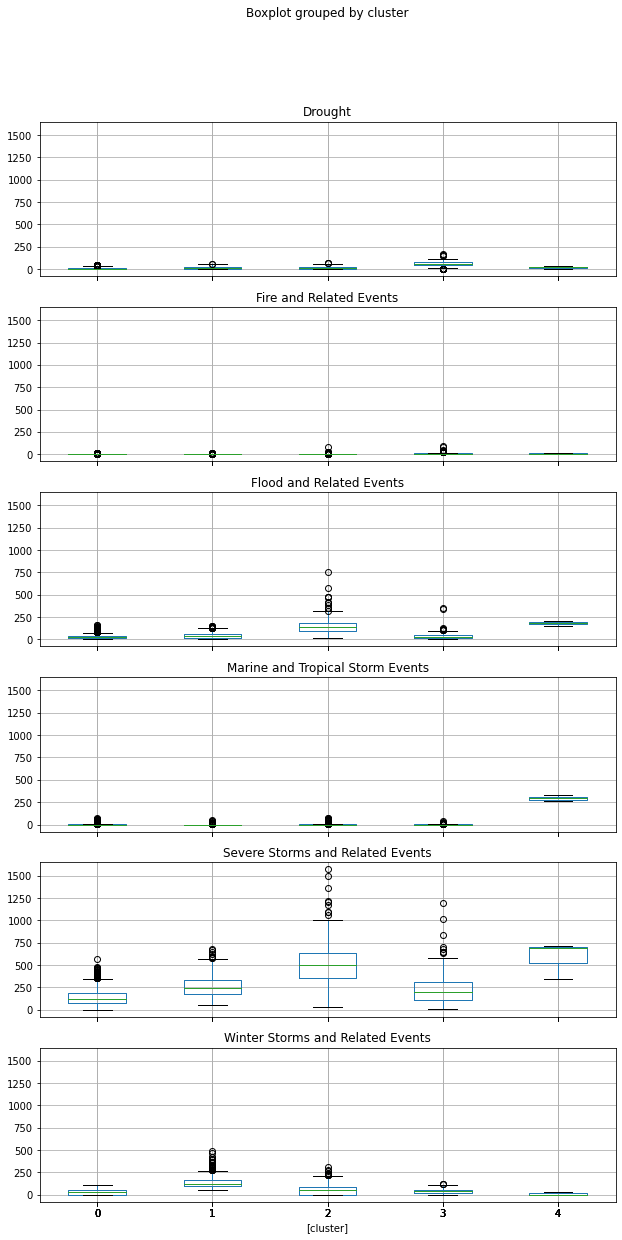

In [25]:
weather_clusters_df.boxplot(by="cluster", layout = (6,1), figsize = (10,20))

### Bartholomew and other specific county values

In [26]:
weather_clusters_df.loc[weather_clusters_df['location'] == 'BARTHOLOMEW, INDIANA', ['cluster', 'location']]

,cluster,location
667,0,"BARTHOLOMEW, INDIANA"


In [27]:
weather_clusters_df.loc[weather_clusters_df['location'] == 'MONROE, INDIANA', ['cluster', 'location']]

,cluster,location
715,0,"MONROE, INDIANA"


In [28]:
weather_clusters_df.loc[weather_clusters_df['location'] == 'MARION, INDIANA', ['cluster', 'location']]

,cluster,location
711,2,"MARION, INDIANA"


In [29]:
weather_clusters_df.loc[weather_clusters_df['location'] == 'VANDERBURGH, INDIANA', ['cluster', 'location']]

,cluster,location
744,1,"VANDERBURGH, INDIANA"


In [30]:
weather_clusters_df.loc[weather_clusters_df['location'] == 'HAMILTON, INDIANA', ['cluster', 'location']]

,cluster,location
692,0,"HAMILTON, INDIANA"


In [31]:
weather_clusters_df.loc[weather_clusters_df['location'] == 'STORY, IOWA', ['cluster', 'location']]

,cluster,location
839,2,"STORY, IOWA"


In [32]:
weather_clusters_df.loc[weather_clusters_df['location'] == 'BROOMFIELD, COLORADO', ['cluster', 'location']]

,cluster,location
225,0,"BROOMFIELD, COLORADO"


### Plot cluster on a US map - not working timed out so code is converted to markdown to prevent running

In [33]:
import folium
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut

# Initialize Nominatim API
geolocator = Nominatim(user_agent="rkfmap") #(https://developer.mapquest.com/documentation)

/Users/rkfische/Library/Python/3.10/lib/python/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [34]:
def findGeocode(city):
       
    # try and catch is used to overcome
    # the exception thrown by geolocator
    # using geocodertimedout  
    try:
        geolocator = Nominatim(user_agent="rkfmap")
        
        return geolocator.geocode(city)
      
    except GeocoderTimedOut:
          
        return findGeocode(city)    


longitude = []
latitude = []

for i in (t):
      
    if findGeocode(i) != None:
           
        loc = findGeocode(i)
          
        # coordinates returned from 
        # function is stored into
        # two separate list
        latitude.append(loc.latitude)
        longitude.append(loc.longitude)
       
    # if coordinate for a city not
    # found, insert "NaN" indicating 
    # missing value 
    else:
        latitude.append(np.nan)
        longitude.append(np.nan)

In [35]:
def create_cluster_map(location_list, zoom_start_level = 5, location =[39.98126, -96.60152] ):
    cluster_map = folium.Map(location = [39.98126, -96.60152], zoom_start = 5)
    locator = RateLimiter(geolocator, min_delay_seconds=1)
    for x in range(len(location_list)+1):
        temp = locator(location_list[x],language ='en', exactly_one=True)
        print(temp.latitude, temp.longitude)
        folium.CircleMarker(location = [temp.latitude, temp.longitude],
                radius = 5, color = 'red', popup = location_list[x]).add_to(cluster_map)
    return cluster_map

    

#### for one cluster

c = weather_clusters_df.loc[weather_clusters_df['cluster']== 3,['location']]
#c = c[0:5]
cluster_map = folium.Map(location = [39.98126, -96.60152], zoom_start = 5)

for index, row in c.iterrows():
    try:
        temp_loc = row['location']
        #print(temp_loc)
        temp = geolocator.geocode(temp_loc)
        #print(temp)
        folium.CircleMarker(location = [temp.latitude, temp.longitude],
                    radius = 5, popup = row['location']).add_to(cluster_map)
    except: 
        pass

cluster_map.save(" cluster_map3.html ")


#### loop to print multiple cluster maps

t = weather_clusters_df.loc[weather_clusters_df['cluster']== 1,['location']]


t =t[0:5]

test_list = t['location'].tolist()

In [36]:
# get the county and state ('location') for a given cluster, create the filename with the cluster number
# send the list of locations to the function for creating the map, save the map


for x in range(1,2):
    #c = weather_clusters_df.loc[weather_clusters_df['cluster']== x, ['location']]
    c = t
    filename = "cluster"+str(x)+".html"
    cluster_map = create_cluster_map(c['location'].tolist())
    cluster_map
    cluster_map.save(filename)

geolocator = Nominatim(user_agent = 'rkfmap') #(https://developer.mapquest.com/documentation)
cluster_map = folium.Map(location = [39.98126, -96.60152], zoom_start = 5)
county_lat_long_dict = {}
for x in test_list:
    temp_loc = x
    temp = geolocator.geocode(temp_loc)
    county_lat_long_dict[x] = [temp.latitude, temp.longitude]
    folium.CircleMarker(location = [temp.latitude, temp.longitude],
                radius = 5, color = 'red', popup = x).add_to(cluster_map)

## FEMA damage assessment $

### Public Assistance - Project Amount $

In [37]:
# merge FEMA Public Assistance NOAA weather clusters on location
pa2_df = pd.merge(pa_df[['disasterNumber','Year', 'applicantId','damageCategoryCode','incidentType',
                         'pwNumber','location','projectAmount']], weather_clusters_df[['location','cluster']], how = 'outer', on=['location'])


In [38]:
#adf[~adf.x1.isin(bdf.x1)]
pa_df[~pa_df.location.isin(weather_clusters_df.location)]

,disasterNumber,declarationDate,incidentType,pwNumber,applicationTitle,applicantId,damageCategoryCode,projectSize,county,countyCode,...,federalShareObligated,totalObligated,obligatedDate,dcc,damageCategory,lastRefresh,hash,id,Year,location
62,1239,1998-08-26 00:00:00+00:00,Severe Storm,64,L - BATCH 1 - IMMEDIATE NEEDS FUNDING,000-U010A-00,B - Protective Measures,Large,Statewide,0,...,3.750000e+05,3.901248e+05,1998-10-16T00:00:00.000Z,B,Protective Measures,2023-03-18T17:02:21.032Z,ecb2e00ca6d3d445328b93cce1b6316eb38f8548,7e080513-9ec5-4c98-8cf4-3ee232aeaf0e,1998,"STATEWIDE, TEXAS"
149,1239,1998-08-26 00:00:00+00:00,Severe Storm,155,Not Provided,000-000B6-00,E - Public Buildings,Small,Statewide,0,...,1.288880e+03,1.353850e+03,1998-10-28T00:00:00.000Z,E,Public Buildings,2023-03-18T17:02:21.032Z,185e972e58676a8fc825f47ce2ae396fd30c12b4,608168dc-b41d-44c9-bac0-bcd7c6823aae,1998,"STATEWIDE, TEXAS"
150,1239,1998-08-26 00:00:00+00:00,Severe Storm,156,Not Provided,000-000B6-00,E - Public Buildings,Small,Statewide,0,...,7.143000e+03,7.503000e+03,1998-10-28T00:00:00.000Z,E,Public Buildings,2023-03-18T17:02:21.032Z,ddfbe39fb97507267c7529130aef0ad6ef56dbb3,aed8b869-9ac5-45cd-87d6-70228307e56a,1998,"STATEWIDE, TEXAS"
224,1239,1998-08-26 00:00:00+00:00,Severe Storm,230,Not Provided,000-00079-00,D - Water Control Facilities,Large,Statewide,0,...,1.089591e+05,1.138670e+05,1998-10-28T00:00:00.000Z,D,Water Control Facilities,2023-03-18T17:02:21.032Z,51f88e0d682fc2bdf1857d12c721f6dcf3bde98f,f6f64b18-39d5-4b2f-a28f-ac0e332a485c,1998,"STATEWIDE, TEXAS"
235,1239,1998-08-26 00:00:00+00:00,Severe Storm,241,L,000-U0105-00,B - Protective Measures,Large,Statewide,0,...,4.320029e+04,4.515295e+04,1999-02-26T00:00:00.000Z,B,Protective Measures,2023-03-18T17:02:21.032Z,16164c57a0a139b369744a7f0a207c3fbf2c2ee0,cbd2ae33-95b1-4b61-84bc-9f83df2e1ef9,1998,"STATEWIDE, TEXAS"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789619,4671,2022-09-21 00:00:00+00:00,Hurricane,550,707990 - Gripinas Ward - Etier Sector 4 - Road,073-99073-00,C - Roads and Bridges,Small,Jayuya,73,...,2.802500e+05,2.802500e+05,2023-06-09T00:00:00.000Z,C,Roads and Bridges,2023-06-10T17:02:42.285Z,db2c6d603471722a4835b680d71cf42d6358775b,accbf51a-f9d1-4f27-a37e-61ee6817061b,2022,"JAYUYA, PUERTO RICO"
789630,4682,2023-01-12 00:00:00+00:00,Severe Storm,14,710309 - Beaver Creek and Elochoman intakes,000-UO3NH-00,A - Debris Removal,Small,Statewide,0,...,1.350000e+04,1.350000e+04,2023-06-08T00:00:00.000Z,A,Debris Removal,2023-06-10T17:02:42.285Z,f2b7d28e00b9492cd3eee7fc81a2be463751b486,9da91379-aa8d-47cc-8af9-f0d24c37a300,2023,"STATEWIDE, WASHINGTON"
789634,4396,2018-09-29 00:00:00+00:00,Typhoon,33,709442 - Public School System Management Costs,000-UVR1C-00,Z - State Management,Small,Statewide,0,...,4.296370e+03,4.296370e+03,2023-06-10T00:00:00.000Z,Z,State Management,2023-06-11T17:02:30.363Z,1dc3506f190fe705b6d24685c216cf08761c25d2,7cf8d5f7-4347-4d90-83e2-630108d10d93,2018,"STATEWIDE, NORTHERN MARIANA ISLANDS"
789635,4482,2020-03-22 00:00:00+00:00,Biological,1447,180850 - Staff Covid-19 Testing (07.01.20 - 06...,000-UYKFF-00,B - Protective Measures,Large,Statewide,0,...,2.705380e+08,2.705380e+08,2023-06-10T00:00:00.000Z,B,Protective Measures,2023-06-11T17:02:30.363Z,c7fbe0e75ee395f96f7050cd639fa01c1a30b837,41971d43-a4c3-41a1-89b3-f24c3f5e86bc,2020,"STATEWIDE, CALIFORNIA"


### Boxplots

Biological           AxesSubplot(0.1,0.559091;0.363636x0.340909)
Severe Storm    AxesSubplot(0.536364,0.559091;0.363636x0.340909)
Snowstorm                AxesSubplot(0.1,0.15;0.363636x0.340909)
dtype: object

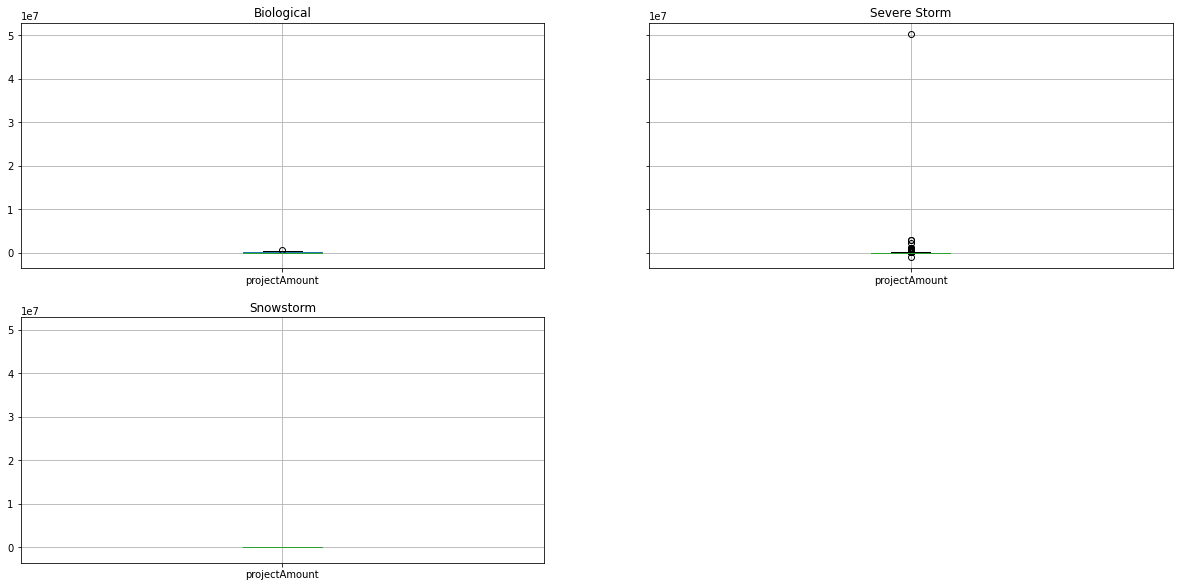

In [39]:
pa2_df[pa2_df['location'] == 'BARTHOLOMEW, INDIANA'][['incidentType', 'projectAmount']].groupby('incidentType').boxplot(figsize=(20,10))

Biological                 AxesSubplot(0.1,0.77069;0.137931x0.12931)
Chemical              AxesSubplot(0.265517,0.77069;0.137931x0.12931)
Coastal Storm         AxesSubplot(0.431034,0.77069;0.137931x0.12931)
Dam/Levee Break       AxesSubplot(0.596552,0.77069;0.137931x0.12931)
Drought               AxesSubplot(0.762069,0.77069;0.137931x0.12931)
Earthquake                AxesSubplot(0.1,0.615517;0.137931x0.12931)
Fire                 AxesSubplot(0.265517,0.615517;0.137931x0.12931)
Flood                AxesSubplot(0.431034,0.615517;0.137931x0.12931)
Freezing             AxesSubplot(0.596552,0.615517;0.137931x0.12931)
Hurricane            AxesSubplot(0.762069,0.615517;0.137931x0.12931)
Mud/Landslide             AxesSubplot(0.1,0.460345;0.137931x0.12931)
Other                AxesSubplot(0.265517,0.460345;0.137931x0.12931)
Severe Ice Storm     AxesSubplot(0.431034,0.460345;0.137931x0.12931)
Severe Storm         AxesSubplot(0.596552,0.460345;0.137931x0.12931)
Snowstorm            AxesSubplot(0

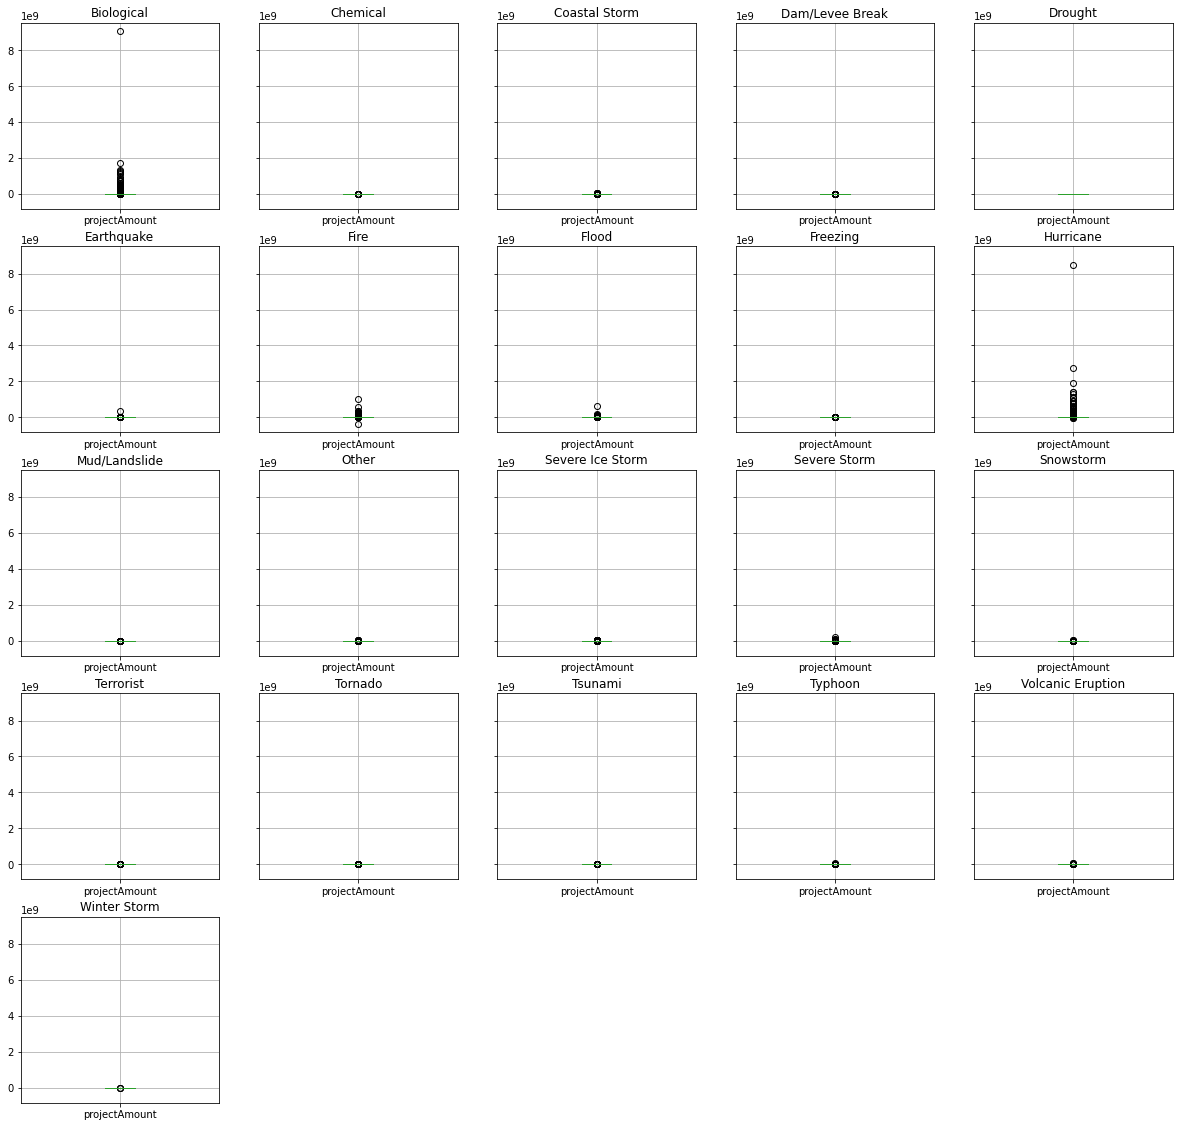

In [40]:
pa2_df[['incidentType', 'projectAmount']].groupby('incidentType').boxplot(figsize=(20,20))

### PA County summaries

In [41]:
# sum the project amount per county and count the records that are summmed
pa_county_df = pa2_df.groupby(by=['cluster', 'location'])['projectAmount'].agg(['sum', 'count'])

In [42]:
# determine the mean of the sum and count by cluster (averaging county values)
print("Mean Total FEMA County Public Assistance by weather cluster: ")
pa_county_df.groupby(by='cluster').mean().apply(lambda x: "{:,.0f}".format(x['sum']), axis=1)

Mean Total FEMA County Public Assistance by weather cluster: 


cluster
0.0     33,462,000
1.0      9,636,774
2.0    107,807,034
3.0      8,870,480
4.0     55,459,884
dtype: object

In [43]:
pa2_county_df=pa_county_df.reset_index()
print("Bartholomew County's total Public Assistance Dollars")
pa2_county_df.loc[pa2_county_df['location'] == 'BARTHOLOMEW, INDIANA', :].apply(lambda x: "{:,.0f}".format(x['sum']), axis=1)


Bartholomew County's total Public Assistance Dollars


84    88,193,806
dtype: object

In [44]:
print("Monroe County's total Public Assistance Dollars")
pa2_county_df.loc[pa2_county_df['location'] == 'MONROE, INDIANA', :].apply(lambda x: "{:,.0f}".format(x['sum']), axis=1)


Monroe County's total Public Assistance Dollars


1078    6,161,062
dtype: object

In [45]:
print("Marion County's total Public Assistance Dollars")
pa2_county_df.loc[pa2_county_df['location'] == 'MARION, INDIANA', :].apply(lambda x: "{:,.0f}".format(x['sum']), axis=1)


Marion County's total Public Assistance Dollars


2649    18,224,343
dtype: object

In [46]:
print("Cluster 1's Public Assistance dollars and count of projects by county")
pa2_county_df.loc[pa2_county_df['cluster'] == 1, :].sort_values('sum',ascending=False).head(5)

Cluster 1's Public Assistance dollars and count of projects by county


,cluster,location,sum,count
2078,1.0,"JOHNSON, IOWA",5.471601e+08,611
2217,1.0,"MORRIS, NEW JERSEY",1.732561e+08,1618
1910,1.0,"DELAWARE, NEW YORK",1.572692e+08,3024
2207,1.0,"MONROE, NEW YORK",1.551677e+08,378
1928,1.0,"DOUGLAS, NEBRASKA",1.367581e+08,614


In [47]:
pa_time_df = pa2_df.groupby(by=['cluster','location', 'Year'])['projectAmount'].agg(['count', 'sum'])
pa_time_df = pa_time_df.reset_index(level=['cluster','Year'])

In [48]:
pa_time_df

,cluster,Year,count,sum
location,,,,
"ABBEVILLE, SOUTH CAROLINA",0.0,2000.0,6,73447.49
"ABBEVILLE, SOUTH CAROLINA",0.0,2015.0,4,452570.57
"ABBEVILLE, SOUTH CAROLINA",0.0,2017.0,4,62663.29
"ACADIA, LOUISIANA",0.0,2002.0,95,5380814.54
"ACADIA, LOUISIANA",0.0,2005.0,69,3463005.60
...,...,...,...,...
"MAUI, HAWAII",4.0,2016.0,14,4893196.73
"MAUI, HAWAII",4.0,2018.0,7,1391063.24
"MAUI, HAWAII",4.0,2020.0,5,1789246.91


In [49]:
pa_time_df['sum'].sum()

95834749013.54999

Summing projectCosts from pa_df: $220,733,575,136.5

Summing projectCosts after merging with clusters locations: $95,834,749,013.55

<AxesSubplot:xlabel='Year'>

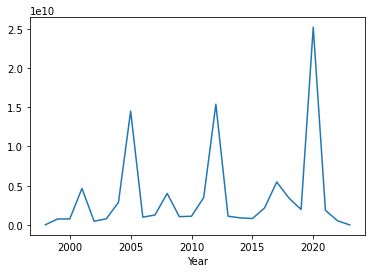

In [50]:
pa_time_df.groupby(by = 'Year')['sum'].sum().plot()

mean 8489752889.867308
upper control limit 43861316011.22689
               x            mR
0   4.995127e+08           NaN
1   1.122331e+09  6.228187e+08
2   9.714616e+08  1.508698e+08
3   6.167713e+09  5.196251e+09
4   9.236424e+08  5.244070e+09
5   1.409482e+09  4.858393e+08
6   3.889657e+09  2.480175e+09
7   2.150939e+10  1.761974e+10
8   1.451146e+09  2.005825e+10
9   2.279098e+09  8.279520e+08
10  6.771623e+09  4.492525e+09
11  2.074126e+09  4.697497e+09
12  1.962750e+09  1.113762e+08
13  4.950034e+09  2.987285e+09
14  1.991524e+10  1.496521e+10
15  1.625655e+09  1.828959e+10
16  1.341593e+09  2.840617e+08
17  1.518438e+09  1.768448e+08
18  3.971441e+09  2.453003e+09
19  4.834878e+10  4.437734e+10
20  7.502163e+09  4.084662e+10
21  2.773733e+09  4.728430e+09
22  7.209992e+10  6.932619e+10
23  3.858271e+09  6.824165e+10
24  1.767208e+09  2.091062e+09
25  2.915667e+07  1.738052e+09
Year 19 out of individual control limits!
Year 22 out of individual control limits!
Year 22 out of Mov

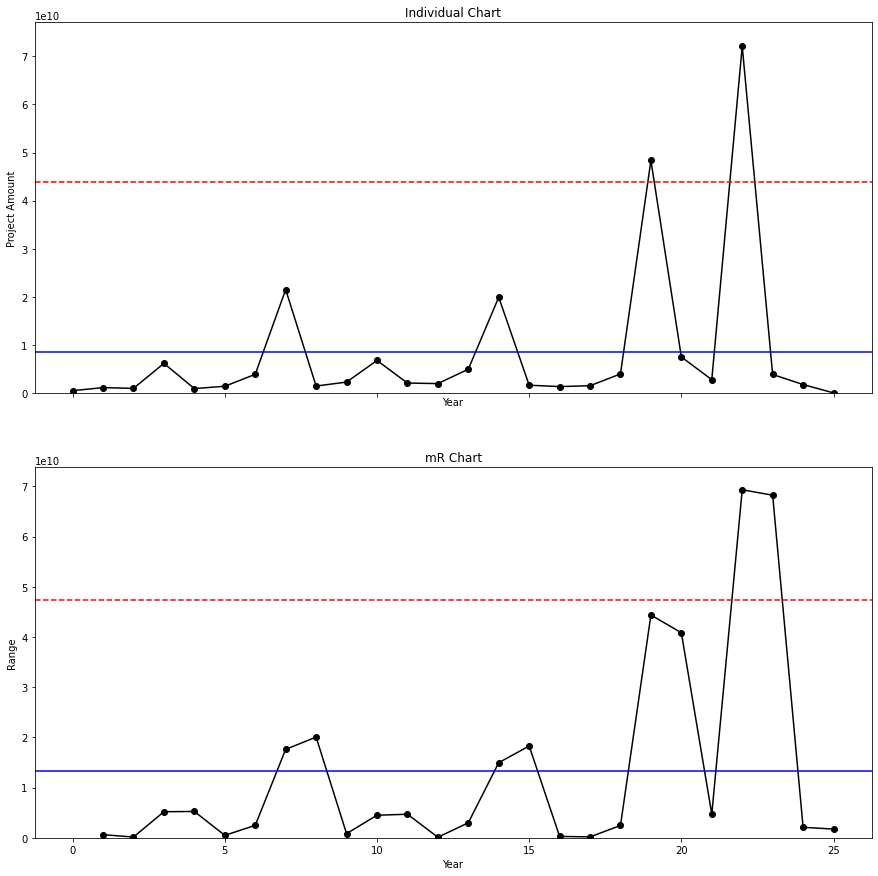

In [51]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics

# Set random seed
np.random.seed(42)

# Load data
x = pd.Series(pa_df.groupby(by = 'Year')['projectAmount'].sum().to_list())

# Define list variable for moving ranges
MR = [np.nan]

# Get and append moving ranges
i = 1
for data in range(1, len(x)):
    MR.append(abs(x[i] - x[i-1]))
    i += 1

# Convert list to pandas Series objects    
MR = pd.Series(MR)

# Concatenate mR Series with and rename columns
data = pd.concat([x,MR], axis=1).rename(columns={0:"x", 1:"mR"})

print("mean", statistics.mean(data['x']))
print("upper control limit", statistics.mean(data['x'])+3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128)
print(data)

# Plot x and mR charts
fig, axs = plt.subplots(2, figsize=(15,15), sharex=True)

# x chart
axs[0].plot(data['x'], linestyle='-', marker='o', color='black')
axs[0].axhline(statistics.mean(data['x']), color='blue')
axs[0].axhline(statistics.mean(data['x'])+3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128, color = 'red', linestyle = 'dashed')
axs[0].axhline(statistics.mean(data['x'])-3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128, color = 'red', linestyle = 'dashed')
axs[0].set_ylim(bottom=0)
axs[0].set_title('Individual Chart')
axs[0].set(xlabel='Year', ylabel='Project Amount')


# mR chart
axs[1].plot(data['mR'], linestyle='-', marker='o', color='black')
axs[1].axhline(statistics.mean(data['mR'][1:len(data['mR'])]), color='blue')
axs[1].axhline(statistics.mean(data['mR'][1:len(data['mR'])])+3*statistics.mean(data['mR'][1:len(data['mR'])])*0.8525, color='red', linestyle ='dashed')
axs[1].axhline(statistics.mean(data['mR'][1:len(data['mR'])])-3*statistics.mean(data['mR'][1:len(data['mR'])])*0.8525, color='red', linestyle ='dashed')
axs[1].set_ylim(bottom=0)
axs[1].set_title('mR Chart')
axs[1].set(xlabel='Year', ylabel='Range')



# Validate points out of control limits for x chart
i = 0
control = True
for unit in data['x']:
    if unit > statistics.mean(data['x'])+3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128 or unit < statistics.mean(data['x'])-3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128:
        print('Year', i, 'out of individual control limits!')
        control = False
    i += 1
if control == True:
    print('All points within control limits.')
    
# Validate points out of control limits for mR chart
i = 0
control = True
for unit in data['mR']:
    if unit > statistics.mean(data['mR'][1:len(data['mR'])])+3*statistics.mean(data['mR'][1:len(data['mR'])])*0.8525 or unit < statistics.mean(data['mR'][1:len(data['mR'])])-3*statistics.mean(data['mR'][1:len(data['mR'])])*0.8525:
        print('Year', i, 'out of Moving Range control limits!')
        control = False
    i += 1
if control == True:
    print('All points within control limits.')

In [52]:
def print_control_chart(value_list):
    # Set random seed
    np.random.seed(42)

    # Create dummy data
    #x = pd.Series(pa_time_df.groupby(by = 'Year')['sum'].sum().to_list())
    x = pd.Series(value_list)

    # Define list variable for moving ranges
    MR = [np.nan]

    # Get and append moving ranges
    i = 1
    for data in range(1, len(x)):
        MR.append(abs(x[i] - x[i-1]))
        i += 1

    # Convert list to pandas Series objects    
    MR = pd.Series(MR)

    # Concatenate mR Series with and rename columns
    #data = pd.concat([x,MR], axis=1).rename(columns={0:"x", 1:"mR"})
    data = pd.concat([x,MR], axis=1).rename(columns={0:"x", 1:"mR"})

    print("mean", statistics.mean(data['x']))
    print("upper control limit", statistics.mean(data['x'])+3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128)
    #print(data)

    # Plot x and mR charts
    fig, axs = plt.subplots(2, figsize=(15,15), sharex=True)

    # x chart
    axs[0].plot(data['x'], linestyle='-', marker='o', color='black')
    axs[0].axhline(statistics.mean(data['x']), color='blue')
    axs[0].axhline(statistics.mean(data['x'])+3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128, color = 'red', linestyle = 'dashed')
    axs[0].axhline(statistics.mean(data['x'])-3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128, color = 'red', linestyle = 'dashed')
    axs[0].set_ylim(bottom=0)
    axs[0].set_title('Individual Chart')
    axs[0].set(xlabel='Year', ylabel='$')


    # mR chart
    axs[1].plot(data['mR'], linestyle='-', marker='o', color='black')
    axs[1].axhline(statistics.mean(data['mR'][1:len(data['mR'])]), color='blue')
    axs[1].axhline(statistics.mean(data['mR'][1:len(data['mR'])])+3*statistics.mean(data['mR'][1:len(data['mR'])])*0.8525, color='red', linestyle ='dashed')
    axs[1].axhline(statistics.mean(data['mR'][1:len(data['mR'])])-3*statistics.mean(data['mR'][1:len(data['mR'])])*0.8525, color='red', linestyle ='dashed')
    axs[1].set_ylim(bottom=0)
    axs[1].set_title('mR Chart')
    axs[1].set(xlabel='Year', ylabel='Range')



    # Validate points out of control limits for x chart
    i = 0
    control = True
    for unit in data['x']:
        if unit > statistics.mean(data['x'])+3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128 or unit < statistics.mean(data['x'])-3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128:
            print('Unit', i, 'out of individual control limits!')
            control = False
        i += 1
    if control == True:
        print('All points within control limits.')

    # Validate points out of control limits for mR chart
    i = 0
    control = True
    for unit in data['mR']:
        if unit > statistics.mean(data['mR'][1:len(data['mR'])])+3*statistics.mean(data['mR'][1:len(data['mR'])])*0.8525 or unit < statistics.mean(data['mR'][1:len(data['mR'])])-3*statistics.mean(data['mR'][1:len(data['mR'])])*0.8525:
            print('Unit', i, 'out of Moving Range control limits!')
            control = False
        i += 1
    if control == True:
        print('All points within control limits.')

In [53]:
pa_time_df

,cluster,Year,count,sum
location,,,,
"ABBEVILLE, SOUTH CAROLINA",0.0,2000.0,6,73447.49
"ABBEVILLE, SOUTH CAROLINA",0.0,2015.0,4,452570.57
"ABBEVILLE, SOUTH CAROLINA",0.0,2017.0,4,62663.29
"ACADIA, LOUISIANA",0.0,2002.0,95,5380814.54
"ACADIA, LOUISIANA",0.0,2005.0,69,3463005.60
...,...,...,...,...
"MAUI, HAWAII",4.0,2016.0,14,4893196.73
"MAUI, HAWAII",4.0,2018.0,7,1391063.24
"MAUI, HAWAII",4.0,2020.0,5,1789246.91


In [54]:
pa_cluster_time_sum_df = pa_time_df.groupby(by = ['cluster','Year'])['sum'].mean()
pa_cluster_time_sum_df.reset_index()
pa_cluster_time_sum_df[0.0].to_list()


[530254.2731578947,
 892556.2072606384,
 718694.7512350598,
 11874861.176750788,
 696898.5071935484,
 755767.1458991227,
 4668176.680020791,
 22844472.119587243,
 1411244.7023193918,
 1700138.2301639344,
 3306029.0705765765,
 1194733.5187816091,
 1053908.2046764705,
 1497981.3002325583,
 39555726.75849265,
 2659600.778914027,
 2380999.403542601,
 840284.3288953488,
 2973865.0068009477,
 4923975.745279999,
 5959679.4183946485,
 1644512.2068636364,
 13264458.933661973,
 4124306.879620253,
 2627890.44869863,
 734704.0655]

Cluster: 0
mean 5185989.225481551
upper control limit 24483810.888079874
Unit 14 out of individual control limits!
Unit 14 out of Moving Range control limits!
Unit 15 out of Moving Range control limits!
Cluster: 1
mean 1314732.036445994
upper control limit 3884418.159815632
All points within control limits.
All points within control limits.
Cluster: 2
mean 11508115.387076762
upper control limit 47095406.8580032
Unit 14 out of individual control limits!
Unit 14 out of Moving Range control limits!
Unit 15 out of Moving Range control limits!
Cluster: 3
mean 1362080.2399284532
upper control limit 5041195.673036836
Unit 22 out of individual control limits!
Unit 23 out of Moving Range control limits!
Cluster: 4
mean 5787293.715686275
upper control limit 17062619.306610476
Unit 13 out of individual control limits!
Unit 14 out of individual control limits!
All points within control limits.


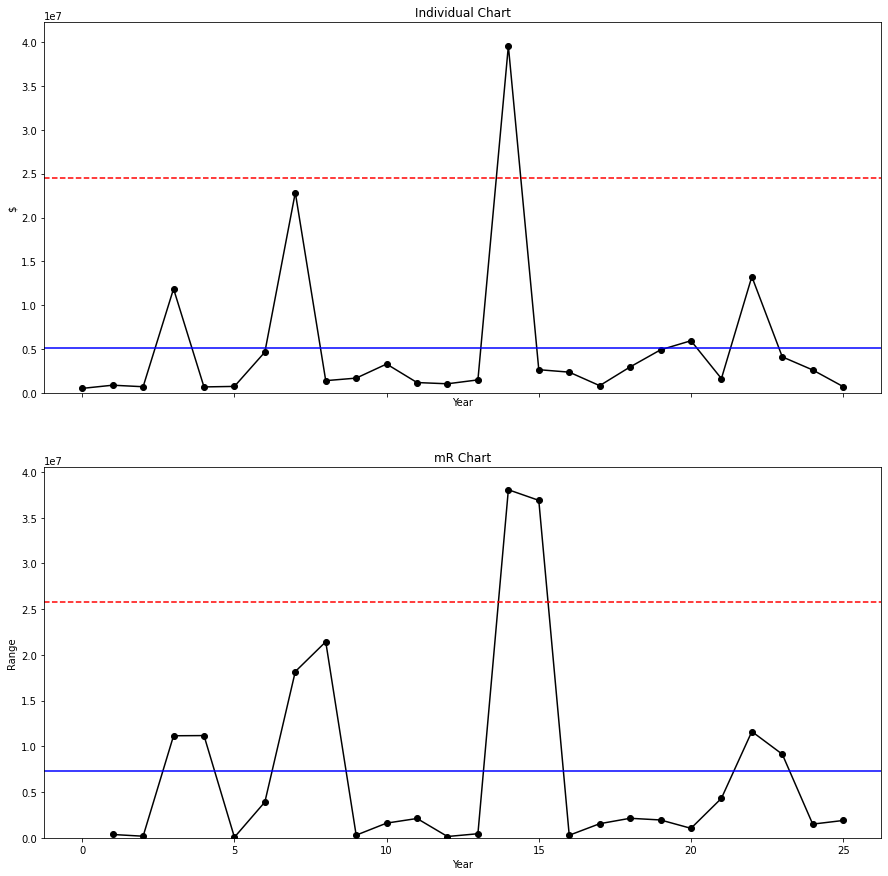

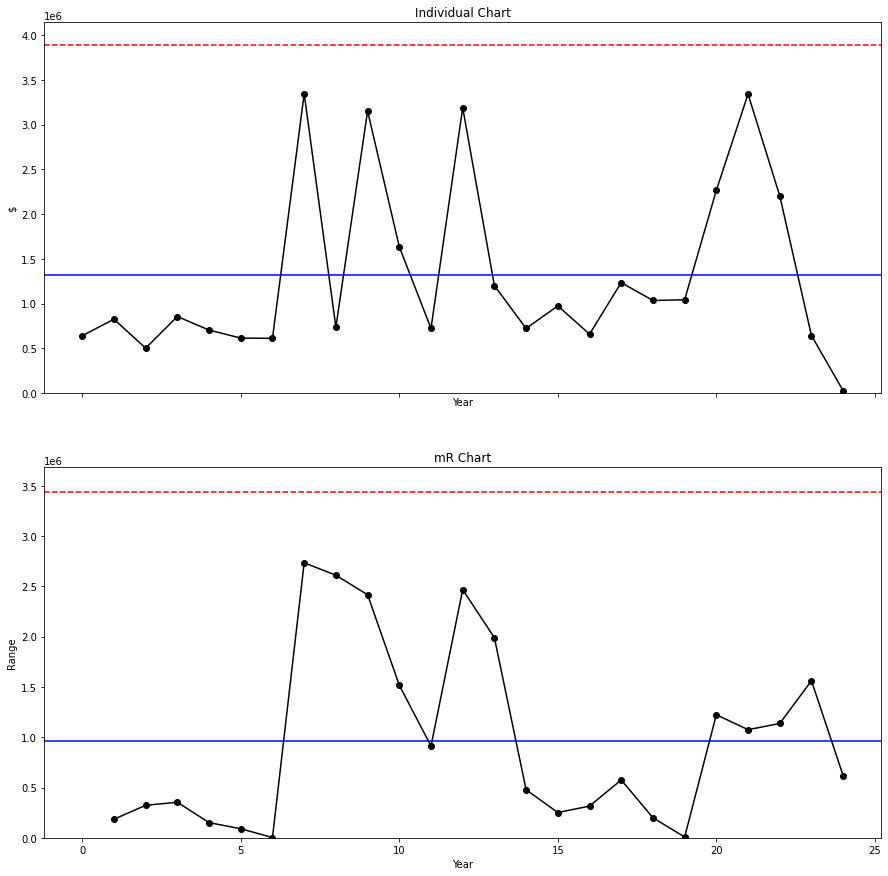

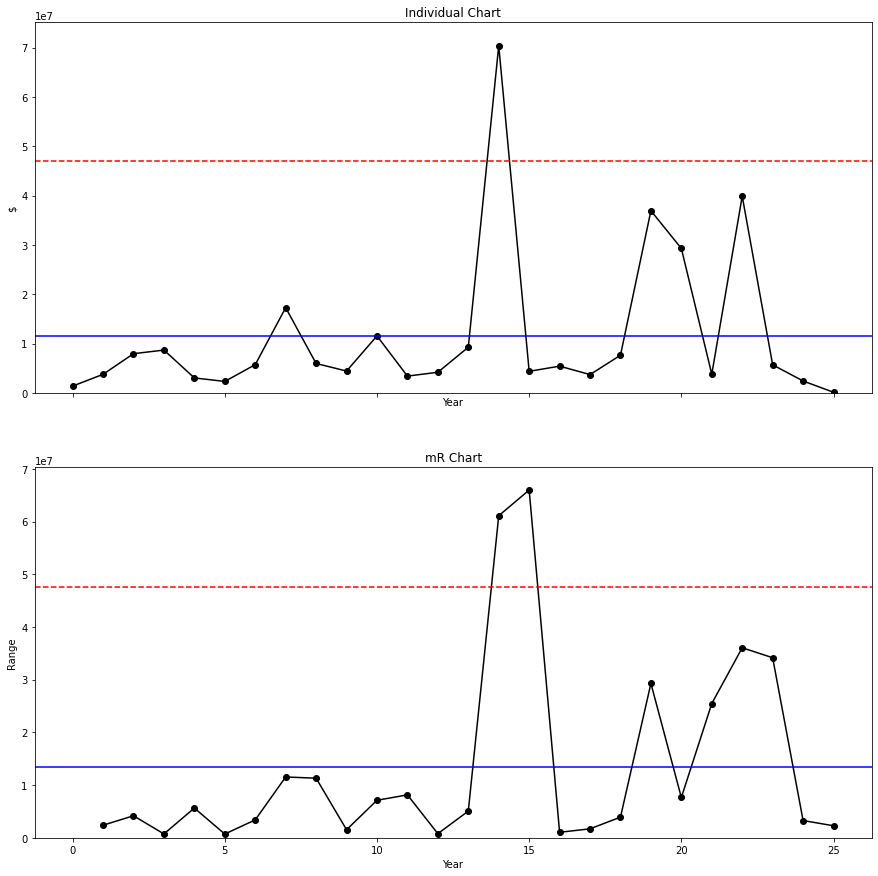

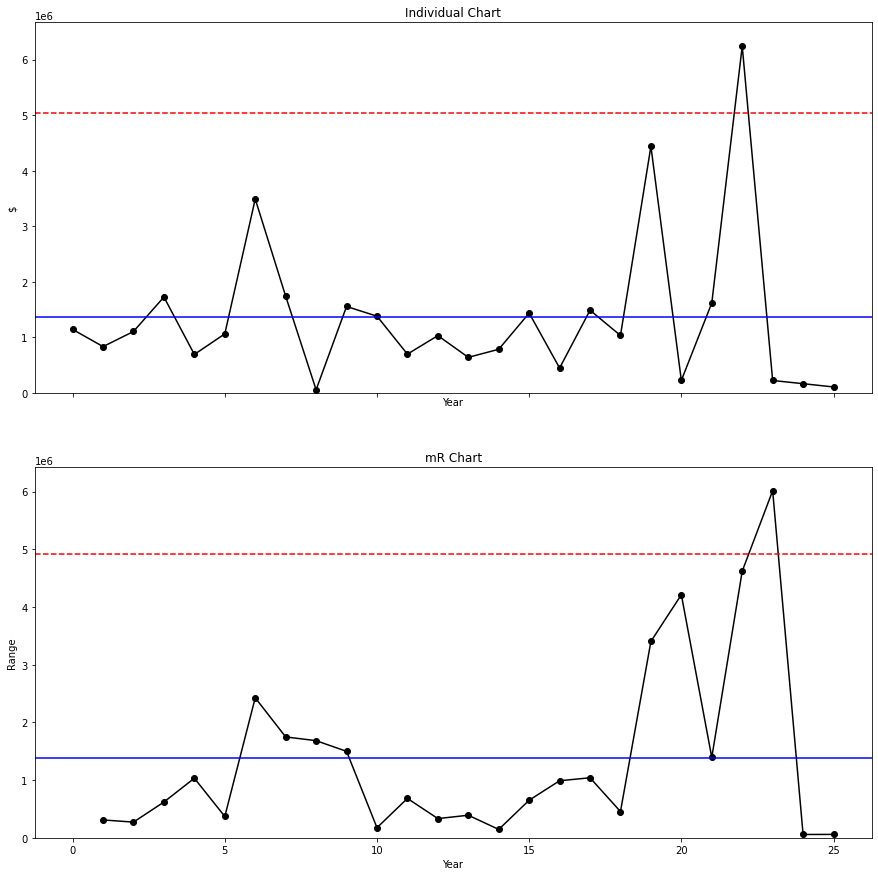

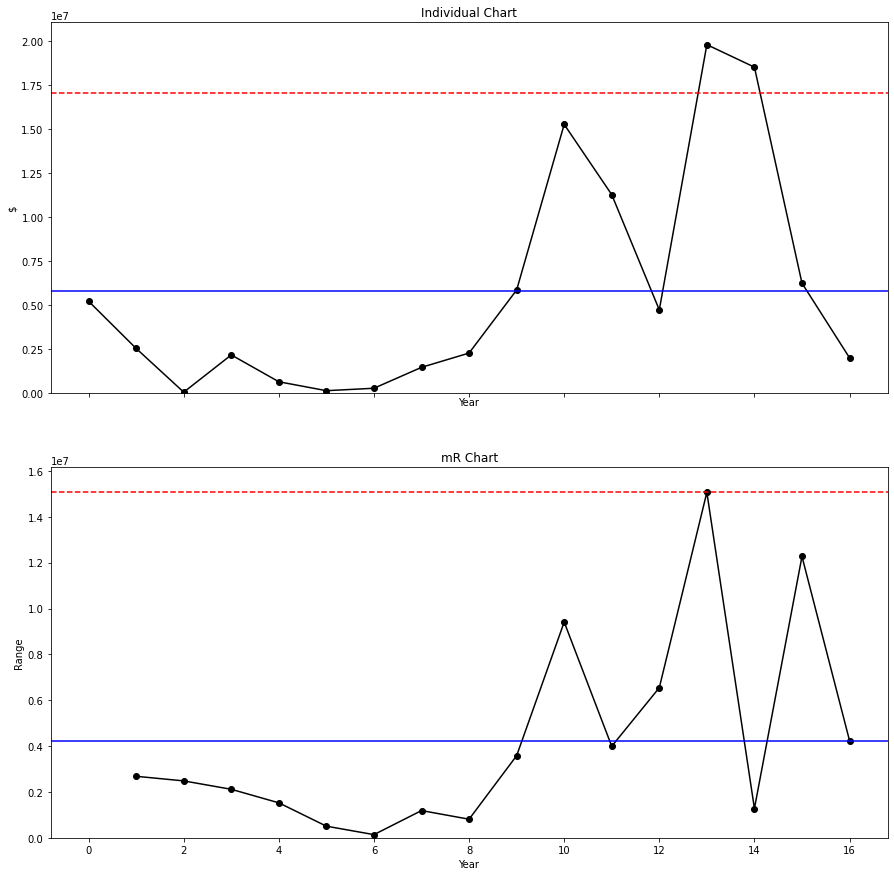

In [55]:
for x in range(0,5):
    print("Cluster:", x)
    p = pa_cluster_time_sum_df[x].to_list()
    print_control_chart(p)

In [56]:
pa_county_time_sum_df = pa_time_df.groupby(by = ['location','Year'])['sum'].mean()
pa_county_time_sum_df.reset_index()
pa_county_time_sum_df['BARTHOLOMEW, INDIANA'].to_list()



#pa2_df[pa2_df['location'] == 'BARTHOLOMEW, INDIANA'][['Year', ]]
#p = pa_cluster_time_sum_df[x].to_list()
#print_control_chart(p)

[443461.87, 85048798.21000001, 2701546.31]

In [57]:
pa_county_time_sum_df

location                   Year  
ABBEVILLE, SOUTH CAROLINA  2000.0      73447.49
                           2015.0     452570.57
                           2017.0      62663.29
ACADIA, LOUISIANA          2002.0    5380814.54
                           2005.0    3463005.60
                                        ...    
ZAVALA, TEXAS              2015.0      42999.89
ZIEBACH, SOUTH DAKOTA      2008.0      97145.67
                           2009.0     365615.21
                           2010.0     222266.39
                           2014.0     183773.47
Name: sum, Length: 18004, dtype: float64

In [58]:
pa_county_time_sum_df['BARTHOLOMEW, INDIANA']

Year
2005.0      443461.87
2008.0    85048798.21
2020.0     2701546.31
Name: sum, dtype: float64

In [59]:
pa_county_time_sum_df['MONROE, INDIANA']

Year
2002.0     271853.03
2005.0     316915.77
2008.0     408602.61
2011.0      63524.85
2020.0    5100165.80
Name: sum, dtype: float64

In [60]:
pa_county_time_sum_df['VANDERBURGH, INDIANA']

Year
2005.0     836007.66
2008.0     885783.65
2009.0    2335993.42
2011.0    1907066.36
2014.0     107339.07
2018.0     774603.26
2020.0    7246302.44
Name: sum, dtype: float64

### Merge Public Assistance with Individual Assistance $ values

Link Public Assistance with Individual Assistance on Disaster Number (disasterNumber)
to get $ for each year (Year) and county (location) by PA, IA Owners and Renters into one file


In [61]:
pa_sm_df = pa_df[['disasterNumber','Year','incidentType',
                         'location','projectAmount']].groupby(['Year','location']).sum(numeric_only=True)

#df.groupby("A").std(numeric_only=True)


In [62]:
pa_sm_df.reset_index()

,Year,location,disasterNumber,projectAmount
0,1998,"AUSTIN, TEXAS",49023,598862.73
1,1998,"BASTROP, TEXAS",93018,813276.38
2,1998,"BEXAR, TEXAS",255171,4807161.93
3,1998,"BURLESON, TEXAS",17598,1551570.21
4,1998,"CALDWELL, TEXAS",51537,597047.22
...,...,...,...,...
19792,2023,"TALLAPOOSA, ALABAMA",23420,184303.36
19793,2023,"TRIPP, SOUTH DAKOTA",18756,26082.74
19794,2023,"TROUP, GEORGIA",9370,33319.35
19795,2023,"WAHKIAKUM, WASHINGTON",18728,33471.83


### IA Owners

In [63]:
ia_owners_df.columns

Index(['disasterNumber', 'state', 'county', 'city', 'zipCode',
       'validRegistrations', 'averageFemaInspectedDamage', 'totalInspected',
       'totalDamage', 'noFemaInspectedDamage',
       'femaInspectedDamageBetween1And10000',
       'femaInspectedDamageBetween10001And20000',
       'femaInspectedDamageBetween20001And30000',
       'femaInspectedDamageGreaterThan30000', 'approvedForFemaAssistance',
       'totalApprovedIhpAmount', 'repairReplaceAmount', 'rentalAmount',
       'otherNeedsAmount', 'approvedBetween1And10000',
       'approvedBetween10001And25000', 'approvedBetween25001AndMax',
       'totalMaxGrants', 'id'],
      dtype='object')

In [64]:
states = {"AL":"Alabama","AK":"Alaska","AZ":"Arizona","AR":"Arkansas","CA":"California","CO":"Colorado","CT":"Connecticut","DE":"Delaware","FL":"Florida","GA":"Georgia","HI":"Hawaii","ID":"Idaho","IL":"Illinois","IN":"Indiana","IA":"Iowa","KS":"Kansas","KY":"Kentucky","LA":"Louisiana","ME":"Maine","MD":"Maryland","MA":"Massachusetts","MI":"Michigan","MN":"Minnesota","MS":"Mississippi","MO":"Missouri","MT":"Montana","NE":"Nebraska","NV":"Nevada","NH":"New Hampshire","NJ":"New Jersey","NM":"New Mexico","NY":"New York","NC":"North Carolina","ND":"North Dakota","OH":"Ohio","OK":"Oklahoma","OR":"Oregon","PA":"Pennsylvania","RI":"Rhode Island","SC":"South Carolina","SD":"South Dakota","TN":"Tennessee","TX":"Texas","UT":"Utah","VT":"Vermont","VA":"Virginia","WA":"Washington","WV":"West Virginia","WI":"Wisconsin","WY":"Wyoming"}


In [65]:
ia_owners_df['county'] = ia_owners_df['county'].str.replace(' (County)',"")
ia_owners_df['County'] = ia_owners_df['county'].str.upper()
ia_owners_df = ia_owners_df.replace({'state': states})
ia_owners_df['State'] = ia_owners_df['state'].str.upper()
ia_owners_df['location'] = (ia_owners_df['County']+", "+ia_owners_df['State'])
ia_owners_df.head()

,disasterNumber,state,county,city,zipCode,validRegistrations,averageFemaInspectedDamage,totalInspected,totalDamage,noFemaInspectedDamage,...,rentalAmount,otherNeedsAmount,approvedBetween1And10000,approvedBetween10001And25000,approvedBetween25001AndMax,totalMaxGrants,id,County,State,location
0,1439,Texas,Aransas,ARANSAS PASS,78335,4,1345.01,3,5380.02,0,...,970.0,1372.89,3,0,0,0,8ec88269-88cb-4099-b075-bd84eaca56df,ARANSAS,TEXAS,"ARANSAS, TEXAS"
1,1439,Texas,Aransas,ARANSAS PASS,78336,68,3082.82,63,209632.06,4,...,23946.0,25674.21,27,26,1,0,0b2917c1-b97f-4785-8f25-16c07c880fdf,ARANSAS,TEXAS,"ARANSAS, TEXAS"
2,1439,Texas,Aransas,FULTON,78358,20,4722.34,18,94446.72,0,...,6784.0,28702.18,3,11,3,0,9f4f4f9f-2e8a-4513-bc61-b0918bc58705,ARANSAS,TEXAS,"ARANSAS, TEXAS"
3,1439,Texas,Aransas,FULTON,78381,1,2578.30,1,2578.30,0,...,726.0,1170.34,1,0,0,0,44a2490b-2056-427e-9648-dd4510a3395c,ARANSAS,TEXAS,"ARANSAS, TEXAS"
4,1439,Texas,Aransas,ROCKPORT,78331,1,0.00,0,0.00,0,...,0.0,0.00,0,0,0,0,46626738-35d3-48ec-a4dd-36bd92f5d7bb,ARANSAS,TEXAS,"ARANSAS, TEXAS"


In [66]:
ia_sm_own_df = ia_owners_df[['disasterNumber',
                         'location','totalDamage']].groupby(['disasterNumber','location']).sum(numeric_only=True)


In [67]:
ia_sm_own_df.reset_index()

,disasterNumber,location,totalDamage
0,1439,"ARANSAS, TEXAS",1505116.17
1,1439,"BRAZORIA, TEXAS",319699.33
2,1439,"CAMERON, TEXAS",1218095.06
3,1439,"FORT BEND, TEXAS",140371.19
4,1439,"HARDIN, TEXAS",310920.24
...,...,...,...
9102,9808,"ALLEGHENY, PENNSYLVANIA",0.00
9103,9808,"BERKS, PENNSYLVANIA",0.00
9104,9808,"CHESTER, PENNSYLVANIA",0.00
9105,9808,"SCHUYLKILL, PENNSYLVANIA",0.00


### IA Renters

In [68]:
ia_renters_df['county'] = ia_renters_df['county'].str.replace(' (County)',"")
ia_renters_df['County'] = ia_renters_df['county'].str.upper()
ia_renters_df = ia_renters_df.replace({'state': states})
ia_renters_df['State'] = ia_renters_df['state'].str.upper()
ia_renters_df['location'] = (ia_renters_df['County']+", "+ia_renters_df['State'])
ia_renters_df.head()

,disasterNumber,state,county,city,zipCode,validRegistrations,totalInspected,totalInspectedWithNoDamage,totalWithModerateDamage,totalWithMajorDamage,...,rentalAmount,otherNeedsAmount,approvedBetween1And10000,approvedBetween10001And25000,approvedBetween25001AndMax,totalMaxGrants,id,County,State,location
0,1439,Texas,Harris,BEAUMONT,70005,1,0,1,0,0,...,0.0,0.00,0,0,0,0.0,8fefcc85-2c48-4c4f-a7e8-699db5ca9eae,HARRIS,TEXAS,"HARRIS, TEXAS"
1,1439,Texas,Walker,MIDWAY,75852,1,1,1,0,0,...,0.0,0.00,0,0,0,0.0,944358d0-c921-4efd-bf31-88a7ccdc83da,WALKER,TEXAS,"WALKER, TEXAS"
2,1439,Texas,Walker,TRINITY,75862,2,2,2,0,0,...,846.0,8790.77,1,0,0,0.0,29a20d13-8037-4587-81a4-a042f1eaa21f,WALKER,TEXAS,"WALKER, TEXAS"
3,1439,Texas,Jasper,JASPER,75951,36,35,36,0,0,...,2886.0,10655.04,10,0,0,0.0,77ff1d9f-de76-4645-aa01-91fbdc35d465,JASPER,TEXAS,"JASPER, TEXAS"
4,1439,Texas,Harris,HOUSTON,77002,1,1,1,0,0,...,0.0,3855.80,1,0,0,0.0,74f01111-570c-4d4e-9d3f-b57e9fef6ccc,HARRIS,TEXAS,"HARRIS, TEXAS"


In [69]:
ia_renters_df.columns

Index(['disasterNumber', 'state', 'county', 'city', 'zipCode',
       'validRegistrations', 'totalInspected', 'totalInspectedWithNoDamage',
       'totalWithModerateDamage', 'totalWithMajorDamage',
       'totalWithSubstantialDamage', 'approvedForFemaAssistance',
       'totalApprovedIhpAmount', 'repairReplaceAmount', 'rentalAmount',
       'otherNeedsAmount', 'approvedBetween1And10000',
       'approvedBetween10001And25000', 'approvedBetween25001AndMax',
       'totalMaxGrants', 'id', 'County', 'State', 'location'],
      dtype='object')

In [70]:
ia_sm_rent_df = ia_renters_df[['disasterNumber',
                         'location','totalApprovedIhpAmount']].groupby(['disasterNumber','location']).sum(numeric_only=True)


In [71]:
ia_sm_rent_df.reset_index()

,disasterNumber,location,totalApprovedIhpAmount
0,1439,"ARANSAS, TEXAS",127102.31
1,1439,"BRAZORIA, TEXAS",45515.34
2,1439,"CAMERON, TEXAS",170394.03
3,1439,"FORT BEND, TEXAS",51120.32
4,1439,"HARDIN, TEXAS",243738.79
...,...,...,...
9441,9808,"LACKAWANNA, PENNSYLVANIA",0.00
9442,9808,"LEHIGH, PENNSYLVANIA",0.00
9443,9808,"MONTGOMERY, PENNSYLVANIA",0.00
9444,9808,"PHILADELPHIA, PENNSYLVANIA",0.00


In [72]:
fema_sm_df = pd.merge(pa_sm_df.reset_index(),ia_sm_own_df.reset_index(), how='outer', on=['disasterNumber', 'location'] )

In [73]:
fema_sm_df = pd.merge(fema_sm_df.reset_index(),ia_sm_rent_df.reset_index(), how='outer', on=['disasterNumber', 'location'] )


In [74]:
fema_sm_df['sum_dlrs'] = fema_sm_df[['projectAmount','totalDamage','totalApprovedIhpAmount']].sum(axis=1, skipna=True)


In [75]:
fema_sm_df.head()

,index,Year,location,disasterNumber,projectAmount,totalDamage,totalApprovedIhpAmount,sum_dlrs
0,0.0,1998.0,"AUSTIN, TEXAS",49023,598862.73,NaN,NaN,598862.73
1,1.0,1998.0,"BASTROP, TEXAS",93018,813276.38,NaN,NaN,813276.38
2,2.0,1998.0,"BEXAR, TEXAS",255171,4807161.93,NaN,NaN,4807161.93
3,3.0,1998.0,"BURLESON, TEXAS",17598,1551570.21,NaN,NaN,1551570.21
4,4.0,1998.0,"CALDWELL, TEXAS",51537,597047.22,NaN,NaN,597047.22


<AxesSubplot:xlabel='Year'>

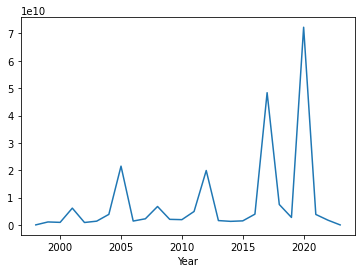

In [76]:
fema_sm_df.groupby('Year')['sum_dlrs'].sum().plot()

<AxesSubplot:xlabel='Year'>

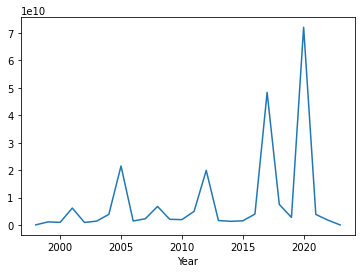

In [77]:
fema_sm_df.groupby('Year')['projectAmount'].sum().plot()

<AxesSubplot:xlabel='Year'>

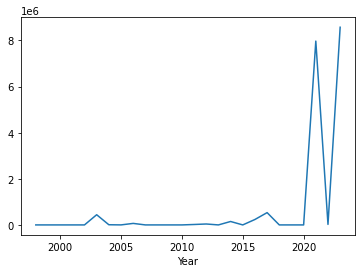

In [78]:
fema_sm_df.groupby('Year')['totalDamage'].sum().plot()

<AxesSubplot:xlabel='Year'>

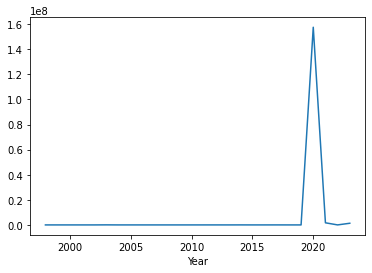

In [79]:
fema_sm_df.groupby('Year')['totalApprovedIhpAmount'].sum().plot()

## Merge FEMA $ with weather cluster

In [80]:
fema_sm_df.head()

,index,Year,location,disasterNumber,projectAmount,totalDamage,totalApprovedIhpAmount,sum_dlrs
0,0.0,1998.0,"AUSTIN, TEXAS",49023,598862.73,NaN,NaN,598862.73
1,1.0,1998.0,"BASTROP, TEXAS",93018,813276.38,NaN,NaN,813276.38
2,2.0,1998.0,"BEXAR, TEXAS",255171,4807161.93,NaN,NaN,4807161.93
3,3.0,1998.0,"BURLESON, TEXAS",17598,1551570.21,NaN,NaN,1551570.21
4,4.0,1998.0,"CALDWELL, TEXAS",51537,597047.22,NaN,NaN,597047.22


In [81]:
fema_merge_df = fema_sm_df.groupby(by = ['Year', 'location'])[['projectAmount', 'totalDamage', 'totalApprovedIhpAmount', 'sum_dlrs']].sum()
                                   
                                   

In [82]:
fema_merge_df.reset_index()

,Year,location,projectAmount,totalDamage,totalApprovedIhpAmount,sum_dlrs
0,1998.0,"AUSTIN, TEXAS",598862.73,0.0,0.0,598862.73
1,1998.0,"BASTROP, TEXAS",813276.38,0.0,0.0,813276.38
2,1998.0,"BEXAR, TEXAS",4807161.93,0.0,0.0,4807161.93
3,1998.0,"BURLESON, TEXAS",1551570.21,0.0,0.0,1551570.21
4,1998.0,"CALDWELL, TEXAS",597047.22,0.0,0.0,597047.22
...,...,...,...,...,...,...
19792,2023.0,"TALLAPOOSA, ALABAMA",184303.36,0.0,0.0,184303.36
19793,2023.0,"TRIPP, SOUTH DAKOTA",26082.74,0.0,0.0,26082.74
19794,2023.0,"TROUP, GEORGIA",33319.35,0.0,0.0,33319.35
19795,2023.0,"WAHKIAKUM, WASHINGTON",33471.83,0.0,0.0,33471.83


In [83]:
fema_cluster_df = pd.merge(fema_merge_df.reset_index(), weather_clusters_df, how = 'outer', on=['location'])


In [84]:
fema_cluster_df

,Year,location,projectAmount,totalDamage,totalApprovedIhpAmount,sum_dlrs,Drought,Fire and Related Events,Flood and Related Events,Marine and Tropical Storm Events,Severe Storms and Related Events,Winter Storms and Related Events,State,County,cluster
0,1998.0,"AUSTIN, TEXAS",598862.73,0.0,0.0,598862.73,10.0,0.0,18.0,3.0,50.0,11.0,TEXAS,AUSTIN,0.0
1,2005.0,"AUSTIN, TEXAS",40927.68,0.0,0.0,40927.68,10.0,0.0,18.0,3.0,50.0,11.0,TEXAS,AUSTIN,0.0
2,2008.0,"AUSTIN, TEXAS",133670.88,0.0,0.0,133670.88,10.0,0.0,18.0,3.0,50.0,11.0,TEXAS,AUSTIN,0.0
3,2015.0,"AUSTIN, TEXAS",776903.18,0.0,0.0,776903.18,10.0,0.0,18.0,3.0,50.0,11.0,TEXAS,AUSTIN,0.0
4,2016.0,"AUSTIN, TEXAS",1514870.48,0.0,0.0,1514870.48,10.0,0.0,18.0,3.0,50.0,11.0,TEXAS,AUSTIN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19855,NaN,"WAYNE, UTAH",NaN,NaN,NaN,NaN,0.0,0.0,131.0,0.0,13.0,0.0,UTAH,WAYNE,0.0
19856,NaN,"FLOYD, VIRGINIA",NaN,NaN,NaN,NaN,12.0,0.0,22.0,1.0,210.0,78.0,VIRGINIA,FLOYD,0.0
19857,NaN,"LINCOLN, WISCONSIN",NaN,NaN,NaN,NaN,29.0,0.0,11.0,0.0,240.0,101.0,WISCONSIN,LINCOLN,1.0
19858,NaN,"CAMPBELL, WYOMING",NaN,NaN,NaN,NaN,0.0,1.0,20.0,0.0,769.0,0.0,WYOMING,CAMPBELL,2.0


## Merge NOAA damage $ (20-year sum)

In [85]:
noaa_dlrs_df = pd.read_csv('NOAA_Cost_AllClusters_All_Counties.csv')

In [86]:
noaa_dlrs_df.columns

Index(['FIPS', 'Avg_Annual_Cost', 'cluster', 'State', 'County'], dtype='object')

In [87]:
noaa_dlrs_df['location'] = noaa_dlrs_df['County']+", "+noaa_dlrs_df['State']

In [88]:
weather_cluster_dlrs_df = pd.merge(fema_cluster_df, noaa_dlrs_df[['location','Avg_Annual_Cost']], how='outer', on='location')


In [89]:
weather_cluster_dlrs_df.columns

Index(['Year', 'location', 'projectAmount', 'totalDamage',
       'totalApprovedIhpAmount', 'sum_dlrs', 'Drought',
       'Fire and Related Events', 'Flood and Related Events',
       'Marine and Tropical Storm Events', 'Severe Storms and Related Events',
       'Winter Storms and Related Events', 'State', 'County', 'cluster',
       'Avg_Annual_Cost'],
      dtype='object')

In [90]:
weather_cluster_dlrs_df['sum_events'] = weather_cluster_dlrs_df[['Drought',
       'Fire and Related Events', 'Flood and Related Events',
       'Marine and Tropical Storm Events', 'Severe Storms and Related Events',
       'Winter Storms and Related Events']].sum(axis=1, skipna=True)

#fema_sm_df['sum_dlrs'] = fema_sm_df[['projectAmount','totalDamage','totalApprovedIhpAmount']].sum(axis=1, skipna=True)

In [91]:
weather_cluster_dlrs_df['NOAAdlrPerEvent'] = (weather_cluster_dlrs_df.Avg_Annual_Cost/weather_cluster_dlrs_df.sum_events).round(2)
weather_cluster_dlrs_df['FEMAdlrPerEvent'] = (weather_cluster_dlrs_df.sum_dlrs/weather_cluster_dlrs_df.sum_events).round(2)

In [92]:
weather_cluster_dlrs_df

,Year,location,projectAmount,totalDamage,totalApprovedIhpAmount,sum_dlrs,Drought,Fire and Related Events,Flood and Related Events,Marine and Tropical Storm Events,Severe Storms and Related Events,Winter Storms and Related Events,State,County,cluster,Avg_Annual_Cost,sum_events,NOAAdlrPerEvent,FEMAdlrPerEvent
0,1998.0,"AUSTIN, TEXAS",598862.73,0.0,0.0,598862.73,10.0,0.0,18.0,3.0,50.0,11.0,TEXAS,AUSTIN,0.0,52408.0,92.0,569.65,6509.38
1,2005.0,"AUSTIN, TEXAS",40927.68,0.0,0.0,40927.68,10.0,0.0,18.0,3.0,50.0,11.0,TEXAS,AUSTIN,0.0,52408.0,92.0,569.65,444.87
2,2008.0,"AUSTIN, TEXAS",133670.88,0.0,0.0,133670.88,10.0,0.0,18.0,3.0,50.0,11.0,TEXAS,AUSTIN,0.0,52408.0,92.0,569.65,1452.94
3,2015.0,"AUSTIN, TEXAS",776903.18,0.0,0.0,776903.18,10.0,0.0,18.0,3.0,50.0,11.0,TEXAS,AUSTIN,0.0,52408.0,92.0,569.65,8444.60
4,2016.0,"AUSTIN, TEXAS",1514870.48,0.0,0.0,1514870.48,10.0,0.0,18.0,3.0,50.0,11.0,TEXAS,AUSTIN,0.0,52408.0,92.0,569.65,16465.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19855,NaN,"WAYNE, UTAH",NaN,NaN,NaN,NaN,0.0,0.0,131.0,0.0,13.0,0.0,UTAH,WAYNE,0.0,81524.0,144.0,566.14,NaN
19856,NaN,"FLOYD, VIRGINIA",NaN,NaN,NaN,NaN,12.0,0.0,22.0,1.0,210.0,78.0,VIRGINIA,FLOYD,0.0,14244.0,323.0,44.10,NaN
19857,NaN,"LINCOLN, WISCONSIN",NaN,NaN,NaN,NaN,29.0,0.0,11.0,0.0,240.0,101.0,WISCONSIN,LINCOLN,1.0,31618.0,381.0,82.99,NaN
19858,NaN,"CAMPBELL, WYOMING",NaN,NaN,NaN,NaN,0.0,1.0,20.0,0.0,769.0,0.0,WYOMING,CAMPBELL,2.0,94979.0,790.0,120.23,NaN


In [93]:
# averaging across years and locations for each cluster

cluster_summary = weather_cluster_dlrs_df.groupby('cluster').mean(numeric_only=True).round(1)

In [94]:
pd.set_option('mode.use_inf_as_na', True)

In [95]:
cluster_summary['NOAAdlrPerEvent'] = (cluster_summary.Avg_Annual_Cost/cluster_summary.sum_events).round(2)
cluster_summary['FEMAdlrPerEvent'] = (cluster_summary.sum_dlrs/cluster_summary.sum_events).round(2)

In [96]:
cluster_summary.to_csv('cluster_summary.csv')

In [149]:
weather_clusters_df.groupby('cluster')['location'].count()

cluster
0    1737
1     769
2     255
3     298
4       3
Name: location, dtype: int64

In [97]:
cluster_summary

,Year,projectAmount,totalDamage,totalApprovedIhpAmount,sum_dlrs,Drought,Fire and Related Events,Flood and Related Events,Marine and Tropical Storm Events,Severe Storms and Related Events,Winter Storms and Related Events,Avg_Annual_Cost,sum_events,NOAAdlrPerEvent,FEMAdlrPerEvent
cluster,,,,,,,,,,,,,,,
0.0,2010.9,6056423.2,1183.8,10803.7,6068410.6,9.3,0.4,31.9,4.5,148.3,34.3,827498.2,228.6,3619.85,26545.98
1.0,2010.7,1568397.8,6.2,6814.7,1575218.7,15.5,0.7,45.9,0.9,261.7,143.6,96981.9,468.2,207.14,3364.41
2.0,2010.7,14148632.8,547.2,8376.1,14157556.1,16.0,2.1,151.1,6.8,517.4,64.5,486412.0,757.9,641.79,18679.98
3.0,2010.6,1543142.4,3270.8,4482.5,1550895.8,62.8,6.9,40.0,1.5,250.6,40.9,211450.9,402.7,525.08,3851.24
4.0,2013.7,6399217.3,0.0,0.0,6399217.3,20.2,8.1,177.9,294.8,620.6,13.5,42691.9,1135.1,37.61,5637.58


In [98]:
cluster_summary.at[1,'FEMAdlrPerEvent']

#df.at[4, 'A'] 

3364.41

## Create clusters from census resilience metrics

In [99]:
census_df.columns.to_list()

['CountyFIPS',
 'GeoId',
 'GeoTemp',
 'Name',
 'StateFIPS',
 '65 plus PE',
 '65 plus PF',
 'Blw Pov Lvl PE',
 'Blw Pov Lvl PF',
 'Blw Pov Lvl PM',
 'Broadband PE',
 'Broadband PF',
 'Broadband PM',
 'civ vet PE',
 'civ vet PF',
 'civ vet PM',
 'crowd occ PE',
 'crowd occ PF',
 'crowd occ PM',
 'Disabled PE',
 'Disabled PF',
 'Disabled PM',
 'Eng Lvw Pe',
 'Eng Lvw Pf',
 'Eng Lvw Pm',
 'Female no partner w child PF',
 'Female no partner w child PM',
 'Female PE',
 'Female PF',
 'GINI IND Inequality E',
 'GINI IND Inequality F',
 'GINI IND Inequality M',
 'Hispanic PE',
 'Hispanic PF',
 'HO Vac PE',
 'HO Vac PF',
 'HO Vac PM',
 'Housing Units E',
 'Housing Units M',
 'HS Grad PE',
 'HS Grad PF',
 'HS Grad PM',
 'Male no partner w child PE',
 'Male no partner w child PF',
 'Male no partner w child PM',
 'Male PE',
 'Male PF',
 'Median age E',
 'Median age F',
 'Median age M',
 'NH AIAN alone PE',
 'NH AIAN alone PF',
 'NH AIAN alone PM',
 'NH Asian alone PE',
 'NH Asian alone PF',
 'NH As

In [100]:
# Change the census fields to caps and remove the word "County", merge the county and state fields
census_df[['county','State']] = census_df['Name'].str.split(',',expand=True)
census_df['State'] = census_df['State'].str.upper()
census_df['County'] = census_df['county'].str.replace(' County', '')
census_df['County'] = census_df['County'].str.upper()
census_df['location'] = census_df['County']+","+census_df['State']

In [101]:
# remove the county titles from the DataFrame so only the measurements are left
county = list(census_df['location'])
del census_df['CountyFIPS']
del census_df['GeoId']
del census_df['GeoTemp']
del census_df['Name']
del census_df['location']
del census_df['county']
del census_df['State']
del census_df['County']
del census_df['StateFIPS']

In [102]:
census_df.head()

,65 plus PE,65 plus PF,Blw Pov Lvl PE,Blw Pov Lvl PF,Blw Pov Lvl PM,Broadband PE,Broadband PF,Broadband PM,civ vet PE,civ vet PF,...,Pred3 Pm,Rent Vac PE,Rent Vac PF,Rent Vac PM,Rural Pop PE,Rural Pop PF,Total Population E,Wrk Ft Yr Pe,Wrk Ft Yr Pf,Wrk Ft Yr Pm
0,15.0,-1,15.2,0,1.8,80.6,-1,1.9,12.6,1,...,9.73,3.1,-1,1.7,42.00,1,55380,52.6,0,2.2
1,20.0,1,10.4,-1,0.9,81.8,0,1.2,11.8,1,...,8.64,43.6,1,2.2,42.28,1,212830,50.5,0,1.1
2,18.6,1,30.7,1,2.4,60.5,-1,2.6,6.6,0,...,10.54,7.4,0,3.0,67.79,2,25361,37.1,-1,2.5
3,15.9,0,18.1,1,4.5,69.2,-1,4.3,8.0,0,...,9.82,5.6,0,5.4,68.35,2,22493,39.7,-1,3.3
4,17.9,1,13.6,0,1.7,73.0,-1,2.5,7.7,0,...,8.18,8.4,0,3.0,89.95,2,57681,47.6,-1,1.7


In [103]:
# Extract all the measurements as a 2D NumPy array, assigning to samples
samples = census_df.values

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
kmeans = KMeans(n_clusters=10)
pipeline = make_pipeline(scaler, kmeans)

In [104]:
pipeline.fit(samples)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=10))])

In [105]:
labels = pipeline.predict(samples)

In [106]:
df2 = pd.DataFrame({'labels': labels, 'location': county})

In [107]:
census_df = pd.read_csv('cre2.csv')

In [108]:
# Change the census fields to caps and remove the word "County", merge the county and state fields
census_df[['county','State']] = census_df['Name'].str.split(',',expand=True)
census_df['State'] = census_df['State'].str.upper()
census_df['County'] = census_df['county'].str.replace(' County', '')
census_df['County'] = census_df['County'].str.upper()
census_df['location'] = census_df['County']+","+census_df['State']

In [109]:
census_df = pd.merge(df2, census_df, how='outer', on='location' )

In [110]:
census_df.loc[census_df['location'] == 'BARTHOLOMEW, INDIANA']['labels']

699    4
Name: labels, dtype: int32

In [111]:
census_df.loc[census_df['location'] == 'MONROE, INDIANA']

,labels,location,CountyFIPS,GeoId,GeoTemp,Name,StateFIPS,65 plus PE,65 plus PF,Blw Pov Lvl PE,...,Rent Vac PM,Rural Pop PE,Rural Pop PF,Total Population E,Wrk Ft Yr Pe,Wrk Ft Yr Pf,Wrk Ft Yr Pm,county,State,County
749,2,"MONROE, INDIANA",105,0500000US18105,0500000US18,"Monroe County, Indiana",18,12.6,-1,23.5,...,1.3,21.25,1,146461,38.5,-1,1.0,Monroe County,INDIANA,MONROE


In [112]:
census_df.loc[census_df['location'] == 'VANDERBURGH, INDIANA']

,labels,location,CountyFIPS,GeoId,GeoTemp,Name,StateFIPS,65 plus PE,65 plus PF,Blw Pov Lvl PE,...,Rent Vac PM,Rural Pop PE,Rural Pop PF,Total Population E,Wrk Ft Yr Pe,Wrk Ft Yr Pf,Wrk Ft Yr Pm,county,State,County
778,4,"VANDERBURGH, INDIANA",163,0500000US18163,0500000US18,"Vanderburgh County, Indiana",18,16.4,1,16.7,...,1.3,9.17,1,181291,52.6,1,0.9,Vanderburgh County,INDIANA,VANDERBURGH


In [113]:
census_df.loc[census_df['location'] == 'MARION, INDIANA']

,labels,location,CountyFIPS,GeoId,GeoTemp,Name,StateFIPS,65 plus PE,65 plus PF,Blw Pov Lvl PE,...,Rent Vac PM,Rural Pop PE,Rural Pop PF,Total Population E,Wrk Ft Yr Pe,Wrk Ft Yr Pf,Wrk Ft Yr Pm,county,State,County
745,2,"MARION, INDIANA",97,0500000US18097,0500000US18,"Marion County, Indiana",18,12.3,-1,17.8,...,0.5,0.6,1,951869,52.0,1,0.5,Marion County,INDIANA,MARION


In [114]:
census_df.loc[census_df['location'] == 'BROOMFIELD, COLORADO']

,labels,location,CountyFIPS,GeoId,GeoTemp,Name,StateFIPS,65 plus PE,65 plus PF,Blw Pov Lvl PE,...,Rent Vac PM,Rural Pop PE,Rural Pop PF,Total Population E,Wrk Ft Yr Pe,Wrk Ft Yr Pf,Wrk Ft Yr Pm,county,State,County
251,2,"BROOMFIELD, COLORADO",14,0500000US08014,0500000US08,"Broomfield County, Colorado",8,13.3,-1,5.6,...,1.4,0.58,1,67886,60.7,1,1.3,Broomfield County,COLORADO,BROOMFIELD


In [115]:
census_df.loc[census_df['location'] == 'STORY, IOWA']

,labels,location,CountyFIPS,GeoId,GeoTemp,Name,StateFIPS,65 plus PE,65 plus PF,Blw Pov Lvl PE,...,Rent Vac PM,Rural Pop PE,Rural Pop PF,Total Population E,Wrk Ft Yr Pe,Wrk Ft Yr Pf,Wrk Ft Yr Pm,county,State,County
873,2,"STORY, IOWA",169,0500000US19169,0500000US19,"Story County, Iowa",19,11.8,-1,20.9,...,1.6,16.94,1,96941,39.5,-1,1.1,Story County,IOWA,STORY


In [116]:
census_df.groupby('labels')['location'].count()

labels
0       2
1     890
2     264
3     413
4    1139
5       1
6     219
7      19
8     159
9      36
Name: location, dtype: int64

In [117]:
census_df.loc[census_df['labels'] == 0]

,labels,location,CountyFIPS,GeoId,GeoTemp,Name,StateFIPS,65 plus PE,65 plus PF,Blw Pov Lvl PE,...,Rent Vac PM,Rural Pop PE,Rural Pop PF,Total Population E,Wrk Ft Yr Pe,Wrk Ft Yr Pf,Wrk Ft Yr Pm,county,State,County
2657,0,"KING, TEXAS",269,0500000US48269,0500000US48,"King County, Texas",48,10.5,0,10.5,...,47.5,100.0,3,237,65.5,0,14.6,King County,TEXAS,KING
2673,0,"LOVING, TEXAS",301,0500000US48301,0500000US48,"Loving County, Texas",48,25.5,0,15.3,...,100.0,100.0,3,98,37.5,0,14.3,Loving County,TEXAS,LOVING


In [118]:
census_df.loc[census_df['labels'] == 5]

,labels,location,CountyFIPS,GeoId,GeoTemp,Name,StateFIPS,65 plus PE,65 plus PF,Blw Pov Lvl PE,...,Rent Vac PM,Rural Pop PE,Rural Pop PF,Total Population E,Wrk Ft Yr Pe,Wrk Ft Yr Pf,Wrk Ft Yr Pm,county,State,County
548,5,"KALAWAO, HAWAII",5,0500000US15005,0500000US15,"Kalawao County, Hawaii",15,16.7,0,10.0,...,8.4,100.0,3,66,72.2,1,15.5,Kalawao County,HAWAII,KALAWAO


In [119]:
census_df.loc[census_df['labels'] == 7, ['labels', 'location']]

,labels,location
103,7,"MARICOPA, ARIZONA"
204,7,"LOS ANGELES, CALIFORNIA"
215,7,"ORANGE, CALIFORNIA"
218,7,"RIVERSIDE, CALIFORNIA"
221,7,"SAN BERNARDINO, CALIFORNIA"
222,7,"SAN DIEGO, CALIFORNIA"
228,7,"SANTA CLARA, CALIFORNIA"
325,7,"BROWARD, FLORIDA"
362,7,"MIAMI-DADE, FLORIDA"
610,7,"COOK, ILLINOIS"


## Find counties that that have the same weather pattern cluster and census cluster

In [120]:
weather_total_df= weather_cluster_dlrs_df

In [121]:
weather_total_df

,Year,location,projectAmount,totalDamage,totalApprovedIhpAmount,sum_dlrs,Drought,Fire and Related Events,Flood and Related Events,Marine and Tropical Storm Events,Severe Storms and Related Events,Winter Storms and Related Events,State,County,cluster,Avg_Annual_Cost,sum_events,NOAAdlrPerEvent,FEMAdlrPerEvent
0,1998.0,"AUSTIN, TEXAS",598862.73,0.0,0.0,598862.73,10.0,0.0,18.0,3.0,50.0,11.0,TEXAS,AUSTIN,0.0,52408.0,92.0,569.65,6509.38
1,2005.0,"AUSTIN, TEXAS",40927.68,0.0,0.0,40927.68,10.0,0.0,18.0,3.0,50.0,11.0,TEXAS,AUSTIN,0.0,52408.0,92.0,569.65,444.87
2,2008.0,"AUSTIN, TEXAS",133670.88,0.0,0.0,133670.88,10.0,0.0,18.0,3.0,50.0,11.0,TEXAS,AUSTIN,0.0,52408.0,92.0,569.65,1452.94
3,2015.0,"AUSTIN, TEXAS",776903.18,0.0,0.0,776903.18,10.0,0.0,18.0,3.0,50.0,11.0,TEXAS,AUSTIN,0.0,52408.0,92.0,569.65,8444.60
4,2016.0,"AUSTIN, TEXAS",1514870.48,0.0,0.0,1514870.48,10.0,0.0,18.0,3.0,50.0,11.0,TEXAS,AUSTIN,0.0,52408.0,92.0,569.65,16465.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19855,NaN,"WAYNE, UTAH",NaN,NaN,NaN,NaN,0.0,0.0,131.0,0.0,13.0,0.0,UTAH,WAYNE,0.0,81524.0,144.0,566.14,NaN
19856,NaN,"FLOYD, VIRGINIA",NaN,NaN,NaN,NaN,12.0,0.0,22.0,1.0,210.0,78.0,VIRGINIA,FLOYD,0.0,14244.0,323.0,44.10,NaN
19857,NaN,"LINCOLN, WISCONSIN",NaN,NaN,NaN,NaN,29.0,0.0,11.0,0.0,240.0,101.0,WISCONSIN,LINCOLN,1.0,31618.0,381.0,82.99,NaN
19858,NaN,"CAMPBELL, WYOMING",NaN,NaN,NaN,NaN,0.0,1.0,20.0,0.0,769.0,0.0,WYOMING,CAMPBELL,2.0,94979.0,790.0,120.23,NaN


In [122]:
census_weather = pd.merge(census_df,weather_cluster_dlrs_df, how='outer', on='location' )

In [123]:
census_weather[census_weather['location']=='BARTHOLOMEW, INDIANA']

,labels,location,CountyFIPS,GeoId,GeoTemp,Name,StateFIPS,65 plus PE,65 plus PF,Blw Pov Lvl PE,...,Marine and Tropical Storm Events,Severe Storms and Related Events,Winter Storms and Related Events,State_y,County_y,cluster,Avg_Annual_Cost,sum_events,NOAAdlrPerEvent,FEMAdlrPerEvent
3571,4.0,"BARTHOLOMEW, INDIANA",5.0,0500000US18005,0500000US18,"Bartholomew County, Indiana",18.0,16.0,1.0,13.4,...,0.0,167.0,36.0,INDIANA,BARTHOLOMEW,0.0,956819.0,265.0,3610.64,1673.44
3572,4.0,"BARTHOLOMEW, INDIANA",5.0,0500000US18005,0500000US18,"Bartholomew County, Indiana",18.0,16.0,1.0,13.4,...,0.0,167.0,36.0,INDIANA,BARTHOLOMEW,0.0,956819.0,265.0,3610.64,320938.86
3573,4.0,"BARTHOLOMEW, INDIANA",5.0,0500000US18005,0500000US18,"Bartholomew County, Indiana",18.0,16.0,1.0,13.4,...,0.0,167.0,36.0,INDIANA,BARTHOLOMEW,0.0,956819.0,265.0,3610.64,10194.51


In [124]:
barth_df = census_weather.query('labels == 4 and cluster == 0')

In [125]:
barth_df

,labels,location,CountyFIPS,GeoId,GeoTemp,Name,StateFIPS,65 plus PE,65 plus PF,Blw Pov Lvl PE,...,Marine and Tropical Storm Events,Severe Storms and Related Events,Winter Storms and Related Events,State_y,County_y,cluster,Avg_Annual_Cost,sum_events,NOAAdlrPerEvent,FEMAdlrPerEvent
0,4.0,"AUTAUGA, ALABAMA",1.0,0500000US01001,0500000US01,"Autauga County, Alabama",1.0,15.0,-1.0,15.2,...,5.0,184.0,17.0,ALABAMA,AUTAUGA,0.0,85232.0,263.0,324.08,752.58
1,4.0,"AUTAUGA, ALABAMA",1.0,0500000US01001,0500000US01,"Autauga County, Alabama",1.0,15.0,-1.0,15.2,...,5.0,184.0,17.0,ALABAMA,AUTAUGA,0.0,85232.0,263.0,324.08,236.08
2,4.0,"AUTAUGA, ALABAMA",1.0,0500000US01001,0500000US01,"Autauga County, Alabama",1.0,15.0,-1.0,15.2,...,5.0,184.0,17.0,ALABAMA,AUTAUGA,0.0,85232.0,263.0,324.08,4.64
3,4.0,"AUTAUGA, ALABAMA",1.0,0500000US01001,0500000US01,"Autauga County, Alabama",1.0,15.0,-1.0,15.2,...,5.0,184.0,17.0,ALABAMA,AUTAUGA,0.0,85232.0,263.0,324.08,1643.88
4,4.0,"AUTAUGA, ALABAMA",1.0,0500000US01001,0500000US01,"Autauga County, Alabama",1.0,15.0,-1.0,15.2,...,5.0,184.0,17.0,ALABAMA,AUTAUGA,0.0,85232.0,263.0,324.08,311.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17699,4.0,"SHERIDAN, WYOMING",33.0,0500000US56033,0500000US56,"Sheridan County, Wyoming",56.0,20.5,1.0,5.9,...,0.0,195.0,0.0,WYOMING,SHERIDAN,0.0,3061.0,214.0,14.30,2631.64
17702,4.0,"SWEETWATER, WYOMING",37.0,0500000US56037,0500000US56,"Sweetwater County, Wyoming",56.0,11.4,-1.0,11.5,...,0.0,73.0,0.0,WYOMING,SWEETWATER,0.0,26247.0,89.0,294.91,1957.59
17703,4.0,"TETON, WYOMING",39.0,0500000US56039,0500000US56,"Teton County, Wyoming",56.0,14.0,-1.0,6.1,...,0.0,52.0,0.0,WYOMING,TETON,0.0,5403.0,67.0,80.64,901.25
17704,4.0,"TETON, WYOMING",39.0,0500000US56039,0500000US56,"Teton County, Wyoming",56.0,14.0,-1.0,6.1,...,0.0,52.0,0.0,WYOMING,TETON,0.0,5403.0,67.0,80.64,3369.03


In [126]:
barth_list = barth_df['location'].unique()


geolocator = Nominatim(user_agent = 'rkfmap') #(https://developer.mapquest.com/documentation)
cluster_map = folium.Map(location = [39.98126, -96.60152], zoom_start = 5)
county_lat_long_dict = {}
for x in barth_list:
    temp_loc = x
    temp = geolocator.geocode(temp_loc)
    county_lat_long_dict[x] = [temp.latitude, temp.longitude]
    folium.CircleMarker(location = [temp.latitude, temp.longitude],
                radius = 5, color = 'red', popup = x).add_to(cluster_map)
cluster_map.save("bartholomew.html")

In [127]:
barth_list

array(['AUTAUGA, ALABAMA', 'BALDWIN, ALABAMA', 'COFFEE, ALABAMA',
       'HOUSTON, ALABAMA', 'ST. CLAIR, ALABAMA',
       'KETCHIKAN GATEWAY BOROUGH, ALASKA', 'GREENE, ARKANSAS',
       'BUTTE, CALIFORNIA', 'EL DORADO, CALIFORNIA',
       'HUMBOLDT, CALIFORNIA', 'NEVADA, CALIFORNIA', 'SHASTA, CALIFORNIA',
       'CLEAR CREEK, COLORADO', 'DOUGLAS, COLORADO', 'ELBERT, COLORADO',
       'FREMONT, COLORADO', 'GRAND, COLORADO', 'GUNNISON, COLORADO',
       'LA PLATA, COLORADO', 'LOGAN, COLORADO', 'MESA, COLORADO',
       'PITKIN, COLORADO', 'SAN MIGUEL, COLORADO', 'SUMMIT, COLORADO',
       'TELLER, COLORADO', 'WASHINGTON, COLORADO',
       'MIDDLESEX, CONNECTICUT', 'NEW LONDON, CONNECTICUT',
       'CLAY, FLORIDA', 'ESCAMBIA, FLORIDA', 'HERNANDO, FLORIDA',
       'INDIAN RIVER, FLORIDA', 'LAKE, FLORIDA', 'MANATEE, FLORIDA',
       'MARTIN, FLORIDA', 'NASSAU, FLORIDA', 'OKALOOSA, FLORIDA',
       'ST. JOHNS, FLORIDA', 'SANTA ROSA, FLORIDA', 'SARASOTA, FLORIDA',
       'WAKULLA, FLORIDA', 'B

## Where are damage costs versus number of events lower/higher than expected?

In [128]:
weather_cluster_dlrs_df.columns

Index(['Year', 'location', 'projectAmount', 'totalDamage',
       'totalApprovedIhpAmount', 'sum_dlrs', 'Drought',
       'Fire and Related Events', 'Flood and Related Events',
       'Marine and Tropical Storm Events', 'Severe Storms and Related Events',
       'Winter Storms and Related Events', 'State', 'County', 'cluster',
       'Avg_Annual_Cost', 'sum_events', 'NOAAdlrPerEvent', 'FEMAdlrPerEvent'],
      dtype='object')

In [129]:
pd.set_option('mode.use_inf_as_na', True)

In [130]:
df1 = weather_cluster_dlrs_df[weather_cluster_dlrs_df['cluster']==1]

In [131]:
cluster_dict = {0: cluster_summary.at[0,'FEMAdlrPerEvent'], 
                1: cluster_summary.at[1,'FEMAdlrPerEvent'],
                2: cluster_summary.at[2,'FEMAdlrPerEvent'],
                3: cluster_summary.at[3,'FEMAdlrPerEvent'],
                4: cluster_summary.at[4,'FEMAdlrPerEvent']}

In [132]:
cluster_dict

{0: 26545.98, 1: 3364.41, 2: 18679.98, 3: 3851.24, 4: 5637.58}

In [133]:
heavy = []
for index, row in df1.iterrows():
    if row['FEMAdlrPerEvent'] > 10*cluster_dict[row['cluster']]:
        heavy.append(row['location'])
set(heavy)

{'ANDROSCOGGIN, MAINE',
 'ARLINGTON, VIRGINIA',
 'BREMER, IOWA',
 'BURLEIGH, NORTH DAKOTA',
 'CASS, NEBRASKA',
 'CATTARAUGUS, NEW YORK',
 'CHENANGO, NEW YORK',
 'CHITTENDEN, VERMONT',
 'DELAWARE, NEW YORK',
 'DICKINSON, KANSAS',
 'DODGE, NEBRASKA',
 'DOUGLAS, NEBRASKA',
 'FRANKLIN, ALABAMA',
 'GUILFORD, NORTH CAROLINA',
 'HAMILTON, TENNESSEE',
 'HENNEPIN, MINNESOTA',
 'JOHNSON, IOWA',
 'JOHNSON, KENTUCKY',
 'KENNEBEC, MAINE',
 'LEHIGH, PENNSYLVANIA',
 'LUZERNE, PENNSYLVANIA',
 'MADISON, ILLINOIS',
 'MILWAUKEE, WISCONSIN',
 'MONROE, NEW YORK',
 'MONTGOMERY, OHIO',
 'MORRIS, NEW JERSEY',
 'NICHOLAS, WEST VIRGINIA',
 'ONONDAGA, NEW YORK',
 'ORANGE, NEW YORK',
 'OTSEGO, NEW YORK',
 'PLATTE, NEBRASKA',
 'POTTAWATTAMIE, IOWA',
 'RAMSEY, MINNESOTA',
 'ROSEAU, MINNESOTA',
 'SANGAMON, ILLINOIS',
 'SCHOHARIE, NEW YORK',
 'SPARTANBURG, SOUTH CAROLINA',
 'ST. JOSEPH, INDIANA',
 'STEELE, MINNESOTA',
 'STEUBEN, NEW YORK',
 'TIOGA, NEW YORK',
 'TOMPKINS, NEW YORK',
 'UNION, SOUTH DAKOTA',
 'WARD, NOR

In [134]:
light = []
for index, row in df1.iterrows():
    if (row['FEMAdlrPerEvent'] < cluster_dict[row['cluster']]/10) and (row['FEMAdlrPerEvent']>1900):
        light.append(row['location'])
set(light)

set()

In [135]:
heavy = []
light = []
for x in range(len(cluster_summary)):
    print(x)
    df = weather_cluster_dlrs_df[weather_cluster_dlrs_df['cluster']==x]    
    for index, row in df.iterrows():
        if row['FEMAdlrPerEvent'] > 10*cluster_dict[row['cluster']]:
            heavy.append((row['cluster'], row['location']))
    for index, row in df.iterrows():
        if (row['FEMAdlrPerEvent'] < cluster_dict[row['cluster']]/10) and (row['FEMAdlrPerEvent']>2500):
            light.append((row['cluster'], row['location']))
heavy =list(set(heavy))
light = list(set(light))

0
1
2
3
4


In [136]:
heavy

[(1.0, 'SPARTANBURG, SOUTH CAROLINA'),
 (3.0, 'REFUGIO, TEXAS'),
 (3.0, 'MACON, ALABAMA'),
 (0.0, 'DEL NORTE, CALIFORNIA'),
 (3.0, 'JACKSON, OREGON'),
 (1.0, 'CHENANGO, NEW YORK'),
 (0.0, 'SANTA BARBARA, CALIFORNIA'),
 (0.0, 'MARION, OREGON'),
 (0.0, 'NAPA, CALIFORNIA'),
 (1.0, 'ORANGE, NEW YORK'),
 (1.0, 'DELAWARE, NEW YORK'),
 (0.0, 'MARTIN, FLORIDA'),
 (1.0, 'CATTARAUGUS, NEW YORK'),
 (0.0, 'JACKSON, MISSISSIPPI'),
 (1.0, 'HENNEPIN, MINNESOTA'),
 (0.0, 'LANE, OREGON'),
 (2.0, 'BROWARD, FLORIDA'),
 (1.0, 'POTTAWATTAMIE, IOWA'),
 (0.0, 'ORLEANS, LOUISIANA'),
 (0.0, 'ST. BERNARD, LOUISIANA'),
 (3.0, 'ORANGE, CALIFORNIA'),
 (1.0, 'ARLINGTON, VIRGINIA'),
 (3.0, 'MONTAGUE, TEXAS'),
 (0.0, 'BUTTE, CALIFORNIA'),
 (0.0, 'CALAVERAS, CALIFORNIA'),
 (3.0, 'CURRY, OREGON'),
 (1.0, 'LEHIGH, PENNSYLVANIA'),
 (0.0, 'SUFFOLK, MASSACHUSETTS'),
 (0.0, 'HARRISON, MISSISSIPPI'),
 (2.0, 'PALM BEACH, FLORIDA'),
 (3.0, 'HIDALGO, TEXAS'),
 (1.0, 'SANGAMON, ILLINOIS'),
 (0.0, 'TERREBONNE, LOUISIANA'),
 (2.0,

In [137]:
heavy[0][1]

'SPARTANBURG, SOUTH CAROLINA'

In [138]:
light.sort()
light

[(0.0, 'ADAMS, PENNSYLVANIA'),
 (0.0, 'AIKEN, SOUTH CAROLINA'),
 (0.0, 'ATKINSON, GEORGIA'),
 (0.0, 'ATLANTIC, NEW JERSEY'),
 (0.0, 'BENTON, MISSISSIPPI'),
 (0.0, 'BLEDSOE, TENNESSEE'),
 (0.0, 'BLOUNT, ALABAMA'),
 (0.0, 'BOONE, ILLINOIS'),
 (0.0, 'BRADLEY, ARKANSAS'),
 (0.0, 'BRAZOS, TEXAS'),
 (0.0, 'BRONX, NEW YORK'),
 (0.0, 'BROOMFIELD, COLORADO'),
 (0.0, 'CALHOUN, ARKANSAS'),
 (0.0, 'CALHOUN, ILLINOIS'),
 (0.0, 'CARROLL, MISSOURI'),
 (0.0, 'CAYUGA, NEW YORK'),
 (0.0, 'CENTRE, PENNSYLVANIA'),
 (0.0, 'CHEROKEE, GEORGIA'),
 (0.0, 'CHESTERFIELD, VIRGINIA'),
 (0.0, 'CLAY, MISSISSIPPI'),
 (0.0, 'CLINCH, GEORGIA'),
 (0.0, 'CONWAY, ARKANSAS'),
 (0.0, 'COOPER, MISSOURI'),
 (0.0, 'DAUPHIN, PENNSYLVANIA'),
 (0.0, 'DAVIDSON, NORTH CAROLINA'),
 (0.0, 'DAVIS, IOWA'),
 (0.0, 'DICKSON, TENNESSEE'),
 (0.0, 'DOUGLAS, OREGON'),
 (0.0, 'DUKES, MASSACHUSETTS'),
 (0.0, 'DUNKLIN, MISSOURI'),
 (0.0, 'EDWARDS, KANSAS'),
 (0.0, 'FRANKLIN, KENTUCKY'),
 (0.0, 'FRANKLIN, MAINE'),
 (0.0, 'FULTON, GEORGIA'),
 (0.

In [139]:
print(len(heavy), len(light))

178 115


In [140]:
heavy_df = pd.DataFrame(heavy, columns = ['cluster', 'location'])

In [141]:
light_df = pd.DataFrame(light, columns = ['cluster', 'location'])

In [142]:
heavy_census_df = pd.merge(heavy_df, census_df, on='location', how='inner' )
light_census_df = pd.merge(light_df, census_df, on='location', how='inner' )

In [143]:
# Create 3 tables: 
# 1) census file subtracting counties in the high and low tables
# 2) high counties 
# 3 low counties
# compare box plot of census values

# All rows in adfthat do not have a match in bdf.
#adf[~adf.x1.isin(bdf.x1)]

middle_census_df = census_df[~census_df.location.isin(heavy_df.location)]
middle_census_df = middle_census_df[~middle_census_df.location.isin(light_df.location)]

In [144]:
heavy_census_df.columns.tolist()

['cluster',
 'location',
 'labels',
 'CountyFIPS',
 'GeoId',
 'GeoTemp',
 'Name',
 'StateFIPS',
 '65 plus PE',
 '65 plus PF',
 'Blw Pov Lvl PE',
 'Blw Pov Lvl PF',
 'Blw Pov Lvl PM',
 'Broadband PE',
 'Broadband PF',
 'Broadband PM',
 'civ vet PE',
 'civ vet PF',
 'civ vet PM',
 'crowd occ PE',
 'crowd occ PF',
 'crowd occ PM',
 'Disabled PE',
 'Disabled PF',
 'Disabled PM',
 'Eng Lvw Pe',
 'Eng Lvw Pf',
 'Eng Lvw Pm',
 'Female no partner w child PF',
 'Female no partner w child PM',
 'Female PE',
 'Female PF',
 'GINI IND Inequality E',
 'GINI IND Inequality F',
 'GINI IND Inequality M',
 'Hispanic PE',
 'Hispanic PF',
 'HO Vac PE',
 'HO Vac PF',
 'HO Vac PM',
 'Housing Units E',
 'Housing Units M',
 'HS Grad PE',
 'HS Grad PF',
 'HS Grad PM',
 'Male no partner w child PE',
 'Male no partner w child PF',
 'Male no partner w child PM',
 'Male PE',
 'Male PF',
 'Median age E',
 'Median age F',
 'Median age M',
 'NH AIAN alone PE',
 'NH AIAN alone PF',
 'NH AIAN alone PM',
 'NH Asian alon

<AxesSubplot:>

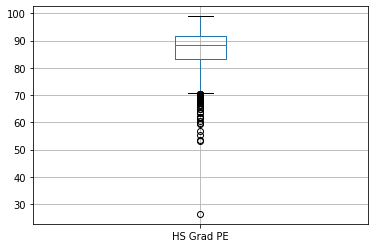

In [145]:
#df.boxplot(by ='day', column =['total_bill'], grid = False)

middle_census_df.boxplot( column = ['HS Grad PE'])

<AxesSubplot:>

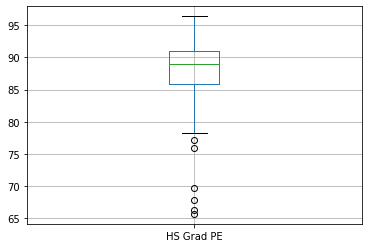

In [146]:
heavy_census_df.boxplot( column = ['HS Grad PE'])

<AxesSubplot:>

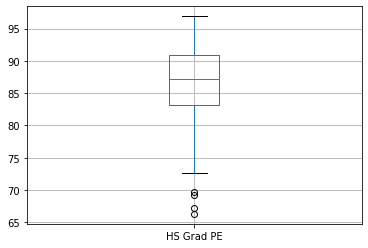

In [147]:
light_census_df.boxplot( column = ['HS Grad PE'])

<AxesSubplot:title={'center':'FEMAdlrPerEvent'}, xlabel='cluster'>

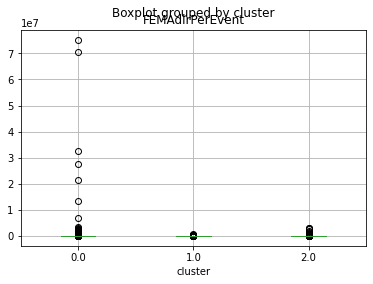

In [148]:
weather_cluster_dlrs_df[weather_cluster_dlrs_df['cluster'] < 3].boxplot(by = 'cluster', column =['FEMAdlrPerEvent'])


#df.boxplot(by ='day', column =['total_bill'], grid = False)

## Comparing the two storm clusters

In [150]:
census_weather.columns.tolist()

['labels',
 'location',
 'CountyFIPS',
 'GeoId',
 'GeoTemp',
 'Name',
 'StateFIPS',
 '65 plus PE',
 '65 plus PF',
 'Blw Pov Lvl PE',
 'Blw Pov Lvl PF',
 'Blw Pov Lvl PM',
 'Broadband PE',
 'Broadband PF',
 'Broadband PM',
 'civ vet PE',
 'civ vet PF',
 'civ vet PM',
 'crowd occ PE',
 'crowd occ PF',
 'crowd occ PM',
 'Disabled PE',
 'Disabled PF',
 'Disabled PM',
 'Eng Lvw Pe',
 'Eng Lvw Pf',
 'Eng Lvw Pm',
 'Female no partner w child PF',
 'Female no partner w child PM',
 'Female PE',
 'Female PF',
 'GINI IND Inequality E',
 'GINI IND Inequality F',
 'GINI IND Inequality M',
 'Hispanic PE',
 'Hispanic PF',
 'HO Vac PE',
 'HO Vac PF',
 'HO Vac PM',
 'Housing Units E',
 'Housing Units M',
 'HS Grad PE',
 'HS Grad PF',
 'HS Grad PM',
 'Male no partner w child PE',
 'Male no partner w child PF',
 'Male no partner w child PM',
 'Male PE',
 'Male PF',
 'Median age E',
 'Median age F',
 'Median age M',
 'NH AIAN alone PE',
 'NH AIAN alone PF',
 'NH AIAN alone PM',
 'NH Asian alone PE',
 'NH 

In [163]:
df = census_weather[census_weather['cluster'].isin([0.0, 2.0])].groupby('cluster').median(numeric_only=True)


#df[df['A'].isin([3, 6])]

In [169]:
df.to_csv("comparingtwoclusters.csv")

In [167]:
df.reset_index().pivot(columns='cluster')

labels      CountyFIPS       StateFIPS       65 plus PE        \
cluster    0.0  2.0        0.0   2.0       0.0   2.0        0.0   2.0   
0          3.0  NaN       77.0   NaN      28.0   NaN       18.7   NaN   
1          NaN  2.0        NaN  59.0       NaN  29.0        NaN  16.5   

        65 plus PF       ... Winter Storms and Related Events        \
cluster        0.0  2.0  ...                              0.0   2.0   
0              1.0  NaN  ...                             33.0   NaN   
1              NaN  1.0  ...                              NaN  49.0   

        Avg_Annual_Cost          sum_events        NOAAdlrPerEvent          \
cluster             0.0      2.0        0.0    2.0             0.0     2.0   
0               44825.0      NaN      224.0    NaN          199.22     NaN   
1                   NaN  75139.0        NaN  695.0             NaN  110.11   

        FEMAdlrPerEvent           
cluster             0.0      2.0  
0               1392.74      NaN  
1                   NaN  1811.41  

[2 rows x 230 columns]

In [173]:
print(df.transpose().to_string())

cluster                                  0.0           2.0
labels                                 3.000  2.000000e+00
CountyFIPS                            77.000  5.900000e+01
StateFIPS                             28.000  2.900000e+01
65 plus PE                            18.700  1.650000e+01
65 plus PF                             1.000  1.000000e+00
Blw Pov Lvl PE                        15.500  1.310000e+01
Blw Pov Lvl PF                         0.000  0.000000e+00
Blw Pov Lvl PM                         2.400  9.000000e-01
Broadband PE                          74.500  8.210000e+01
Broadband PF                          -1.000  0.000000e+00
Broadband PM                           2.700  9.000000e-01
civ vet PE                             8.500  7.900000e+00
civ vet PF                             1.000  1.000000e+00
civ vet PM                             1.100  4.000000e-01
crowd occ PE                           0.500  6.000000e-01
crowd occ PF                          -1.000 -1.000000e+